# Text Classification + Row Text Processing

The general path of Machine Learning:<br>
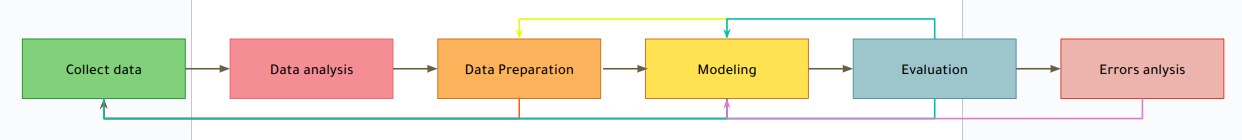

In [1]:
import nltk
from nltk.tokenize import RegexpTokenizer, TreebankWordTokenizer, TweetTokenizer, TreebankWordDetokenizer
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt            # library for visualization
import matplotlib
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud

In [2]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Supervised Classification
What is Classification in general?
- Classification is the task of choosing the correct class label for a given input.

Text Classification:

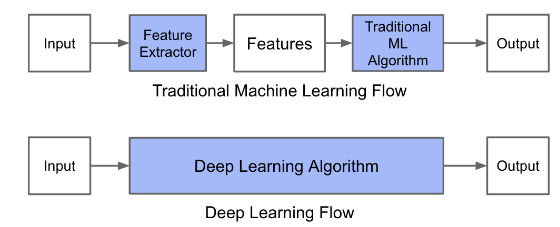

- Text classification is a way to categorize *documents* or *pieces of text*. By examining the word usage in a piece of text, classifiers can decide what **class label** to assign to it.


## Applications
- Spam	filtering
- Topic	detection
- Language	detection
- Sentiment Analysis
- ...

## Our Problem

### Our Dataset: Disasters on social media
Contributors looked at over 10,000 tweets retrieved with a variety of searches like “ablaze”, “quarantine”, and “pandemonium”, then noted whether the tweet referred to a disaster event (as opposed to a joke with the word or a movie review or something non-disastrous).

In [3]:
data = pd.read_csv("socialmedia_disaster.csv")
data.head(20)

text  label
0                  Just happened a terrible car crash      1
1   Our Deeds are the Reason of this #earthquake M...      1
2   Heard about #earthquake is different cities, s...      1
3   there is a forest fire at spot pond, geese are...      1
4              Forest fire near La Ronge Sask. Canada      1
5   All residents asked to 'shelter in place' are ...      1
6   13,000 people receive #wildfires evacuation or...      1
7   Just got sent this photo from Ruby #Alaska as ...      1
8   #RockyFire Update => California Hwy. 20 closed...      1
9            Apocalypse lighting. #Spokane #wildfires      1
10  #flood #disaster Heavy rain causes flash flood...      1
11      Typhoon Soudelor kills 28 in China and Taiwan      1
12                 We're shaking...It's an earthquake      1
13  I'm on top of the hill and I can see a fire in...      1
14  There's an emergency evacuation happening now ...      1
15  I'm afraid that the tornado is coming to our a...      1
16        Three people died from the heat wave so far      1
17  Haha South Tampa is getting flooded hah- WAIT ...      1
18  #raining #flooding #Florida #TampaBay #Tampa 1...      1
19            #Flood in Bago Myanmar #We arrived Bago      1

## Solution



### 1.Data Analysis

before any step taken towards understanding your data, split it (if not)-into training and testing sets (at least) to avoide **data leakage**. <br><br>
Data leakage is when information from outside the training dataset is used to create the model, it usually leads to overly optimistic outcomes during the model building phase, followed by the unpleasant surprise of poor results after the prediction model is implemented and tested on new data.


In [4]:
X = data["text"].tolist()
y = data["label"].tolist()

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40)

In [ ]:
len(X_train)

7476

In [ ]:
len(X_test)

1870

In [ ]:
X_train[:2]

['Angry Orchard Hard Cider Recalled Due To Threat of Exploding Bottles http://t.co/OXgefsoF2B',
 '@guardian Has Japan ever truly come to terms with devastation and mass murder of millions of Chinese and others with traditional weapons?']

In [ ]:
y_train[:2]

[1, 1]

We convert our dataset lists to dataframe to use pandas functions that make it easier for us to work on the data.

In [6]:
train_df = pd.DataFrame({'text': X_train, 'label':y_train})
train_df.head()

text  label
0  Angry Orchard Hard Cider Recalled Due To Threa...      1
1  @guardian Has Japan ever truly come to terms w...      1
2  Plains All American Pipeline company may have ...      1
3  People are finally panicking about cable TV ht...      0
4  The far right racist #AvigdorLiberman calls fo...      1

In [7]:
test_df = pd.DataFrame({'text': X_test, 'label':y_test})

The goal of **data analysis** is discovering useful information by informing conclusions and supporting decision making (gain an insight on our data).

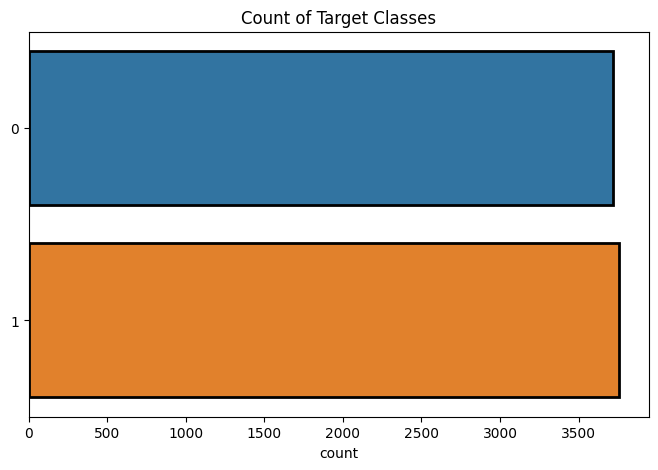

In [ ]:
# Visualizing the target classes
plt.figure(figsize=(8,5))
plt.title("Count of Target Classes")
sns.countplot(y=y_train, linewidth=2,
                   edgecolor='black')

plt.show()

Let's start by analysing total number of characters in text:

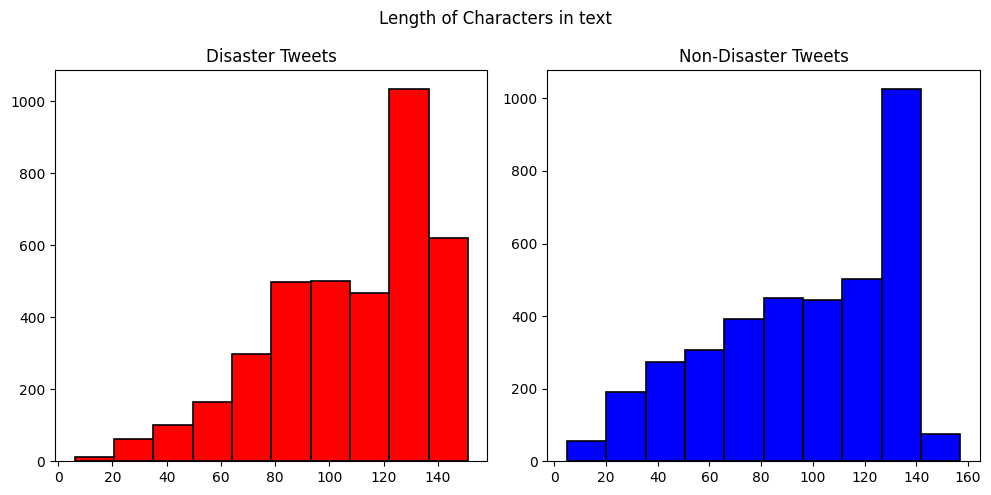

In [10]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
char_len_dis = train_df[train_df['label'] == 1]['text'].str.len()
ax1.hist(char_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets')

char_len_ndis = train_df[train_df['label'] == 0]['text'].str.len()
ax2.hist(char_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets')

plt.suptitle("Length of Characters in text")
plt.tight_layout()
plt.show()

In [11]:
char_len_dis

0        91
1       137
2       132
4       139
5        73
       ... 
7465    138
7467     81
7468    102
7469    139
7472    143
Name: text, Length: 3758, dtype: int64

Analysing number of words in text:

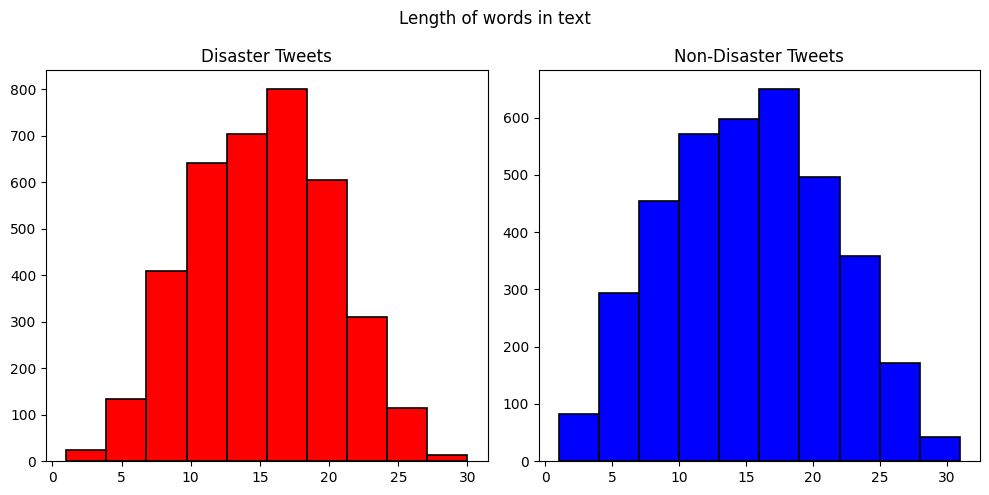

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
words_len_dis = train_df[train_df['label'] == 1]['text'].str.split().map(lambda x: len(x))
ax1.hist(words_len_dis,color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster Tweets')

words_len_ndis = train_df[train_df['label'] == 0]['text'].str.split().map(lambda x: len(x))
ax2.hist(words_len_ndis,color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('Non-Disaster Tweets')

plt.suptitle("Length of words in text")
plt.tight_layout()
plt.show()

**Frequency Analyses**<br><br>
To visualize text data, generally, we use the `wordcloud` but there are some other techniques also, which we can try to visualize the data such as  `Frequency Distribution`

Word Cloud is a data visualization technique in which words from a given text display on the main chart. Some properties associated with this chart are as follows:

- In this technique, more frequent or essential words display in a larger and bolder font,
- While less frequent or essential words display in smaller or thinner fonts.
This data visualization technique gives us a glance at what text should be analyzed, so it is a very beneficial technique in NLP tasks.

**Advantages of Word Cloud**<br>
- They are fast.
- They are engaging.
- They are simple to understand.
- They are casual and visually appealing.

**Disadvantages of Word Cloud**<br>
- They are non-perfect for non-clean data.
- They lack the context of words.


Here, to draw the word cloud, we use the following text:


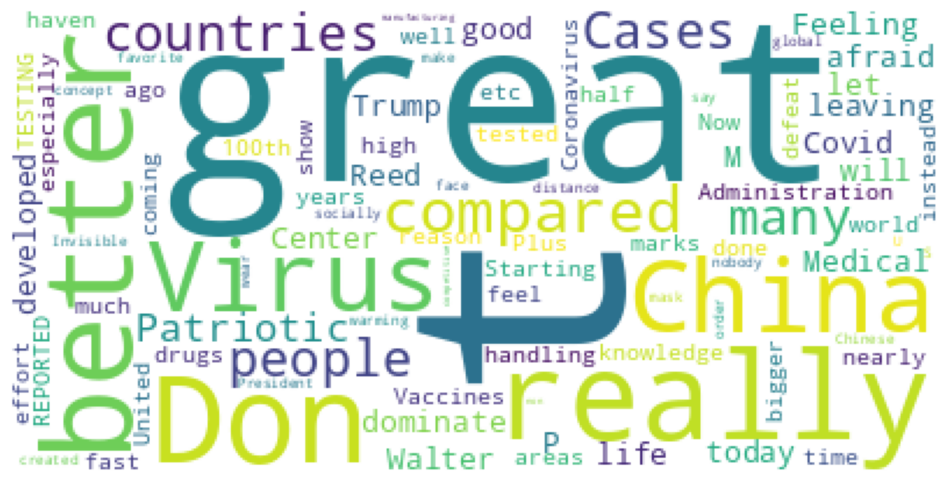

In [ ]:
text = "I will be leaving the great Walter Reed Medical Center today at 6:30 P.M. Feeling really good! Don’t be afraid of Covid. Don’t let it dominate your life. We have developed, under the Trump Administration, some really great drugs & knowledge. I feel better than I did 20 years ago! Starting to get VERY high marks in our handling of the Coronavirus (China Virus), especially when compared to other countries and areas of the world. Now the Vaccines (Plus) are coming, and fast! For the 1/100th time, the reason we show so many Cases, compared to other countries that haven’t done nearly as well as we have, is that our TESTING is much bigger and better. We have tested 40,000,000 people. If we did 20,000,000 instead, Cases would be half, etc. NOT REPORTED! We are United in our effort to defeat the Invisible China Virus, and many people say that it is Patriotic to wear a face mask when you can’t socially distance. There is nobody more Patriotic than me, your favorite President! The concept of global warming was created by and for the Chinese in order to make U.S. manufacturing non-competitive."

wordcloud = WordCloud(background_color ='white',).generate(text)
plt.figure(figsize = (12,12))
plt.imshow(wordcloud)

plt.axis("off")
plt.show()

In [ ]:
wordcloud.words_

{'t': 1.0,
 'great': 0.5,
 'really': 0.5,
 'Don': 0.5,
 'better': 0.5,
 'China': 0.5,
 'Virus': 0.5,
 'compared': 0.5,
 'countries': 0.5,
 'many': 0.5,
 'Cases': 0.5,
 'people': 0.5,
 'Patriotic': 0.5,
 'will': 0.25,
 'leaving': 0.25,
 'Walter': 0.25,
 'Reed': 0.25,
 'Medical': 0.25,
 'Center': 0.25,
 'today': 0.25,
 'P': 0.25,
 'M': 0.25,
 'Feeling': 0.25,
 'good': 0.25,
 'afraid': 0.25,
 'Covid': 0.25,
 'let': 0.25,
 'dominate': 0.25,
 'life': 0.25,
 'developed': 0.25,
 'Trump': 0.25,
 'Administration': 0.25,
 'drugs': 0.25,
 'knowledge': 0.25,
 'feel': 0.25,
 'years': 0.25,
 'ago': 0.25,
 'Starting': 0.25,
 'high': 0.25,
 'marks': 0.25,
 'handling': 0.25,
 'Coronavirus': 0.25,
 'especially': 0.25,
 'areas': 0.25,
 'world': 0.25,
 'Now': 0.25,
 'Vaccines': 0.25,
 'Plus': 0.25,
 'coming': 0.25,
 'fast': 0.25,
 '100th': 0.25,
 'time': 0.25,
 'reason': 0.25,
 'show': 0.25,
 'haven': 0.25,
 'done': 0.25,
 'nearly': 0.25,
 'well': 0.25,
 'TESTING': 0.25,
 'much': 0.25,
 'bigger': 0.25,
 '

In [13]:
class1_text = " ".join(train_df[train_df['label'] == 1]['text'].tolist())
class2_text = " ".join(train_df[train_df['label'] == 0]['text'].tolist())

disaster_cloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                min_font_size = 10).generate(class1_text)

non_disaster_cloud = WordCloud(width = 1000, height = 800,
                background_color ='white',
                min_font_size = 10).generate(class2_text)

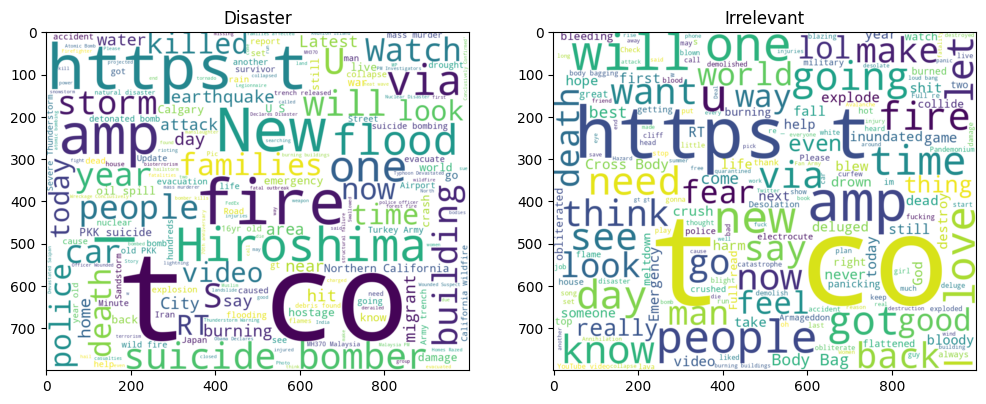

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axes[0].imshow(disaster_cloud, interpolation="bilinear")
axes[0].title.set_text('Disaster')

axes[1].imshow(non_disaster_cloud, interpolation="bilinear")
axes[1].title.set_text('Irrelevant')

### 2.Data prepration

`Preprocessing` is a critical step that involves the transformation and cleaning of raw text in such a way that it becomes easy to understand and efficient to work with.

These preprocessing techniques help to reduce the complexity of the language data, improving computational efficiency and performance of the models. However, these techniques need to be applied judiciously, keeping in mind the requirements of the specific NLP task.


**What is text?**
You can think of text as a sequence of
- Characters
- **Words**
- Phrases and named entities
- Sentences
- Paragraphs
- ...


**What is a word?**<br>
- A word is a meaningful sequence of characters<br>
**How to find the boundaries of words?**<br>
- In *English* we can split a sentence by spaces or punctuation
    - Friends, Romans, Countrymen, lendme your ears;
    - Output:[Friends, Romans, Countrymen, lend, me, your, ears]
- In *German* there are compound words which are written without spaces
    - “Rechtsschutzversicherungsgesellschaften” stands for “insurance companies which provide legal protection”
- In *Japanese* there are no spaces at all!
    - Butyoucanstillreaditright?
- In *Arabic*?

Let's take some examples:

How many words are in the following sentence?

- <font color='skyblue'>He stepped out into the hall, was delighted to encounter a water brother.</font>

  This sentence has <font color='orangered'>13 words</font> if we don’t count punctuation marks as words, <font color='orangered'>15</font> if we count punctuation.
  
  Whether we treat period (“.”), comma (“,”), and so on as words `depends on the task`. Punctuation is critical for finding boundaries of things (commas, periods, colons) and for identifying some aspects of meaning (question marks, exclamation marks, quotation marks). For some tasks, like part-of-speech tagging or parsing or speech synthesis, we sometimes treat punctuation marks as if they were separate words.

- <font color='skyblue'>I do uh main- mainly business data processing</font>

  This utterance has two kinds of <font color='lightgreen'>disfluencies</font>. The broken-off word main- is called a <font color='lightgreen'>fragment</font>. Words like uh and um are called <font color='lightgreen'>fillers or filled pauses</font>. `Should we consider these to be words? `Again, it depends on the application. If we are building a speech transcription system, we might want to eventually strip out the disfluencies. But we also sometimes keep disfluencies around. Disfluencies like uh or um are actually helpful in speech recognition in predicting the upcoming word, because they may signal that the speaker is restarting the clause or idea, and so for speech recognition they are treated as regular words.

- <font color='skyblue'>They picnicked by the pool, then lay back on the grass and looked at the stars.</font>

  `Should we consider a capitalized string (like They) and one that is uncapitalized (like they) to be the same word type?` The answer is that it depends on the task! They and they might be lumped together as the same type in some tasks, like speech recognition, where we care more about the sequence of words and less about the formatting, while for other tasks, such as deciding whether a particular word is a name of a person or location (named entity tagging), capitalization is a useful feature and is retained.

- It’s also quite common for speakers or writers to use multiple languages in a single communicative act, a phenomenon called <font color='lightgreen'>code switching</font>.





#### 2.1. Tokenization
Tokenization is a process that *splits* an input sequence into so-called **tokens**.
- You can think of a token as a **useful unit** for semantic processing.
- Can be a word, sentence, paragraph, etc.
- Tokenizers are reversible and lossless, enabling the transformation of tokens back into the original text without any loss of information.
- NLTK includes some off-the-shelf tokenizers:

In [ ]:
text = "This is Andrew’s text, isn’t it?"

Whitespace tokenizer

In [ ]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
tokens = tokenizer.tokenize(text)
print(tokens)

['This', 'is', 'Andrew’s', 'text,', 'isn’t', 'it?']


Word Punctution Tokenizer

In [ ]:
tokenizer = nltk.tokenize.WordPunctTokenizer()
tokens = tokenizer.tokenize(text)
print(tokens)

['This', 'is', 'Andrew', '’', 's', 'text', ',', 'isn', '’', 't', 'it', '?']


Regular Expression Tokenizer<br>
We can come up with a set of rules

In [ ]:
s = "Good muffins cost $3.88\nin New York.  Please buy me\ntwo of them.\n\nThanks."
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')
print(tokenizer.tokenize(s))

['Good', 'muffins', 'cost', '$3.88', 'in', 'New', 'York', '.', 'Please', 'buy', 'me', 'two', 'of', 'them', '.', 'Thanks', '.']


This may go wrong in many ways...

Treebank Word Tokenizer

In [ ]:
text = "Good muffins cost $3.88\nin New York. Please buy me\ntwo of them.\n\nThanks."
print(text + "\n______________")
tokenizer = TreebankWordTokenizer()
print(tokenizer.tokenize(text))

Good muffins cost $3.88
in New York.  Please buy me
two of them.

Thanks.
______________
['Good', 'muffins', 'cost', '$', '3.88', 'in', 'New', 'York.', 'Please', 'buy', 'me', 'two', 'of', 'them.', 'Thanks', '.']


What about the dots at the sentences ends?!

The Treebank tokenizer uses regular expressions to tokenize text as in Penn Treebank.

This tokenizer performs the following steps:

- split standard contractions, e.g. don't -> do n't and they'll -> they 'll.

- treat most punctuation characters as separate tokens.

- split off commas and single quotes, when followed by whitespace.

- separate periods that appear at the end of line.

*Note that word_tokenize works only at the sentence level. So you'll have to split at the sentence level and the tokenize the sentences.*

In [ ]:
text = "Good muffins cost $3.88\nin New York. Please buy me\ntwo of them.\n\nThanks."
tokenizer = TreebankWordTokenizer()
sents = nltk.sent_tokenize(text)
print(sents)
print(tokenizer.tokenize_sents(sents))

['Good muffins cost $3.88\nin New York.', 'Please buy me\ntwo of them.', 'Thanks.']
[['Good', 'muffins', 'cost', '$', '3.88', 'in', 'New', 'York', '.'], ['Please', 'buy', 'me', 'two', 'of', 'them', '.'], ['Thanks', '.']]


The most use-sentence segmentation fulcues for segmenting a text into sentences are punctuation, like periods, question marks, and exclamation points. Question marks and exclamation points are relatively unambiguous markers of sentence boundaries. Periods, on the other hand, are more ambiguous. The period character “.” is ambiguous between a sentence boundary marker and a marker of <font color='orangered'>abbreviations like Mr. or Inc.</font> The previous sentence that you just read showed an even more complex case of this ambiguity, in which the final period of Inc. marked both an abbreviation and the sentence boundary marker. For this reason, sentence tokenization and word tokenization may be addressed jointly.


Some drawbacks to the Treebank style:

- Contractions like (isn't) should be splited into 2 tokens.
- Almost all tokens that involve punctuation are split apart — URLs, Twitter mark-up, phone numbers, dates, email addresses ... Thus, emoticons are collapsed with their component parts, URLs are not constituents, and Twitter mark-up is lost.

Special case: Tweeter Tokenizer

In [ ]:
tweet = data.iloc[83]['text']
print(tweet)
tokenizer = TweetTokenizer()
print(tokenizer.tokenize(tweet))

Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB
['Experts', 'in', 'France', 'begin', 'examining', 'airplane', 'debris', 'found', 'on', 'Reunion', 'Island', ':', 'French', 'air', 'accident', 'experts', 'on', '...', 'http://t.co/TagZbcXFj0', '#MLB']


The tokenization choice obviously depends on your task, for example if your task is sentiment analysis, you should think of a tokenizer achive:

- Isolates emoticons
- Respects Twitter and other domain-specific markup
- Uses the underlying mark-up (e.g., \<strong\> tags)
- Captures those #$%ing masked curses!
- Preserves capitalization where it seems meaningful
- Regularizes lengthening (e.g., YAAAAAAY⇒YAAAY)
- Captures significant multiword expressions (e.g., out of
this world)

for Example:

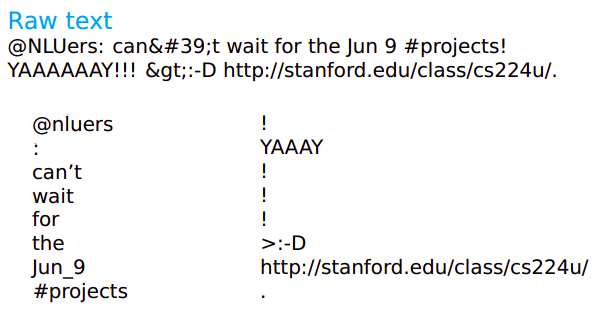

You can detokenize text using NLTK Tokenizers as following:

In [ ]:
tokenizer = TreebankWordTokenizer()
detokenizer = TreebankWordDetokenizer()

print(f'Original Tweet: {tweet}')

tokens = tokenizer.tokenize(tweet)
print(f'Tweet Tokens: {tokens}')

tweet = detokenizer.detokenize(tokens)
print(f'Detokenized tweet: {tweet}')

Original Tweet: Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on...http: //t.co/TagZbcXFj0 #MLB
Tweet Tokens: ['Experts', 'in', 'France', 'begin', 'examining', 'airplane', 'debris', 'found', 'on', 'Reunion', 'Island', ':', 'French', 'air', 'accident', 'experts', 'on', '...', 'http', ':', '//t.co/TagZbcXFj0', '#', 'MLB']
Detokenized tweet: Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on...http: //t.co/TagZbcXFj0 #MLB


**Exercise**:

Try to tokenize and normalize the input text to get the expected output by regular expression:<brr>

**input text**: I was walking towards my house evening, and suddenly a black-coat man appeared in front of me !!!I was scared sooooo much . .. but it turned out that he was just a homeless , I gave him 5.5$ and made my way home.

**expected output**: i was walking towards my house evening , and suddenly a black-coat man appeared in front of me ! i was scared so much ... but it turned out that he was just a homeless , i gave him 5.5 $ and made my way home .



In [ ]:
###### your code ######

#### 2.2 Token normalization
- This is an optional step that may improve your classification.
- We may want the same token for different forms of the word
    - wolf, wolves -> wolf
    - talk, talks -> talk

##### **Stemming**<br>
- A process of removing and **replacing suffixes** to get to the root form of the word, which is called the **stem**
- Usually refers to **heuristics** that chop off suffixes

In [14]:
raw = """DENNIS: Listen, strange women lying in ponds distributing swords
... is no basis for a system of government.  Supreme executive power derives from
... a mandate from the masses, not from some farcical aquatic ceremony. mice"""
tokenizer = TreebankWordTokenizer()
tokens = tokenizer.tokenize(raw)

**Porter Stemmer**<br>
- 5 heuristic phases of word reductions, applied sequentially
- Example of phase 1 rules:
    - SSES → SS <br>
        e.g. caresses → caress
    - IES→ I <br>
        e.g. ponies →poni
    - SS→ SS <br>
        e.g. caress → caress
    - S→ <br>
        e.g. cats → cat
    - ATIONAL → ATE <br>
        e.g., relational → relate
    - ING →  <br>
        e.g., motoring → motor

more at https://tartarus.org/martin/PorterStemmer/


In [15]:
porter = nltk.PorterStemmer()
[(t, porter.stem(t)) for t in tokens]

[('DENNIS', 'denni'),
 (':', ':'),
 ('Listen', 'listen'),
 (',', ','),
 ('strange', 'strang'),
 ('women', 'women'),
 ('lying', 'lie'),
 ('in', 'in'),
 ('ponds', 'pond'),
 ('distributing', 'distribut'),
 ('swords', 'sword'),
 ('is', 'is'),
 ('no', 'no'),
 ('basis', 'basi'),
 ('for', 'for'),
 ('a', 'a'),
 ('system', 'system'),
 ('of', 'of'),
 ('government.', 'government.'),
 ('Supreme', 'suprem'),
 ('executive', 'execut'),
 ('power', 'power'),
 ('derives', 'deriv'),
 ('from', 'from'),
 ('a', 'a'),
 ('mandate', 'mandat'),
 ('from', 'from'),
 ('the', 'the'),
 ('masses', 'mass'),
 (',', ','),
 ('not', 'not'),
 ('from', 'from'),
 ('some', 'some'),
 ('farcical', 'farcic'),
 ('aquatic', 'aquat'),
 ('ceremony.', 'ceremony.'),
 ('mice', 'mice')]

Problems:
- Fails on irregular forms, produces non-words.
- over-generalizating (e.g. policy to police) and under-generalizing (not stemming European to Europe).

**LancasterStemmer**<br>

Like the Porter stemmer, the Lancaster stemmer consists of a set of rules where each rule specifies either deletion or replacement of an ending. Also, some rules are restricted to intact words, and some rules are applied iteratively as the word goes through them.

In [ ]:
lancaster = nltk.LancasterStemmer()
[(t,lancaster.stem(t)) for t in tokens]

[('DENNIS', 'den'),
 (':', ':'),
 ('Listen', 'list'),
 (',', ','),
 ('strange', 'strange'),
 ('women', 'wom'),
 ('lying', 'lying'),
 ('in', 'in'),
 ('ponds', 'pond'),
 ('distributing', 'distribut'),
 ('swords', 'sword'),
 ('is', 'is'),
 ('no', 'no'),
 ('basis', 'bas'),
 ('for', 'for'),
 ('a', 'a'),
 ('system', 'system'),
 ('of', 'of'),
 ('government.', 'government.'),
 ('Supreme', 'suprem'),
 ('executive', 'execut'),
 ('power', 'pow'),
 ('derives', 'der'),
 ('from', 'from'),
 ('a', 'a'),
 ('mandate', 'mand'),
 ('from', 'from'),
 ('the', 'the'),
 ('masses', 'mass'),
 (',', ','),
 ('not', 'not'),
 ('from', 'from'),
 ('some', 'som'),
 ('farcical', 'farc'),
 ('aquatic', 'aqu'),
 ('ceremony.', 'ceremony.'),
 ('mice', 'mic')]

**The dangers of stemming:**<br>

Stemming can sometimes be a rudimentary method, as it merely truncates the ends of words using simplistic rules without understanding the context. This can lead to erroneous outputs where the stemmed word is not a valid word or has a different meaning.

Stemming collapses distinct word forms!!<br>

as an example:


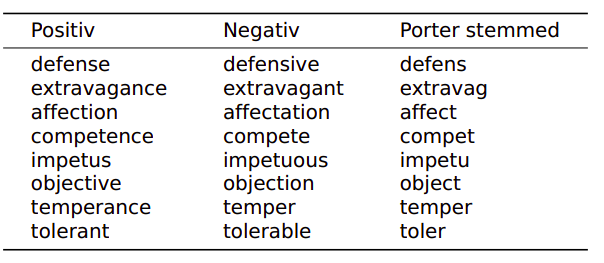

##### **Lemmatization**
- Usually refers to doing things properly with the use of a vocabulary and **morphological analysis**
- Returns the base or dictionary form of a word, which is known as the **lemma**
- The process involves understanding the context and part of speech of the word, making it more complex and accurate than stemming.
For example, the word “better” has “good” as its lemma. Lemmatization would correctly identify this, while stemming would not. the complexity of lemmatization can also make it computationally more expensive than stemming.


In [ ]:
wnl = nltk.WordNetLemmatizer()
lemmatizedTokens =[wnl.lemmatize(t) for t in tokens]
for index, (token, lemma) in enumerate(zip(tokens, lemmatizedTokens)):
    print(token + "\t" + lemma)

DENNIS	DENNIS
:	:
Listen	Listen
,	,
strange	strange
women	woman
lying	lying
in	in
ponds	pond
distributing	distributing
swords	sword
is	is
no	no
basis	basis
for	for
a	a
system	system
of	of
government.	government.
Supreme	Supreme
executive	executive
power	power
derives	derives
from	from
a	a
mandate	mandate
from	from
the	the
masses	mass
,	,
not	not
from	from
some	some
farcical	farcical
aquatic	aquatic
ceremony.	ceremony.
mice	mouse


didn't handle lying, not all forms are reduced.

#### 2.3 Further Token normalization

Convert to lowercase.
Remove punctuation from each token.
Filter out remaining tokens that are not alphabetic.

1. Normalizing capital letters<br>
  Useually we simply lowercase each letter
  but it is not always prefect because:
  - Us, us -> us(if both are pronoun)
  - us, US (could be pronoun and country)
  - We can use heuristics:
      −lowercasing the beginning of the sentence
      −lowercasing words in titles
      −leave mid-sentence words as they are
    - Or we can use machine learning to retrieve true casing -> hard
     
     
2. Noise Entities Removal<br>
  Noise is considered as that piece of text which is not relevant to the context of the data and the final output.
  For Example,
  - URLs or links,
  - Social media entities (mentions, hashtags),
  - Punctuations, and Industry-Specific words.

3. Filter out remaining tokens that are not alphabetic.<br>
  Non-alphanumeric characters include any characters that are not letters or digits, like ">" and "?".

4. Spell Check and Correction:
Typos and spelling mistakes are common in text data. Spell check and correction can be used to correct these errors. This step can help in reducing multiple copies of words. For example, “speling” and “spelling” will be considered as two different words unless corrected.

5. Converting numbers to their word equivalents?
    


`How to know which cleaning operation is suitable for our task?`

Now lets clean and standarize our data:

In [8]:
# remove empty rows
train_df = train_df.dropna()
train_df = train_df.drop_duplicates()
train_df.shape

(7368, 2)

In [9]:
test_df = test_df.dropna()
test_df = test_df.drop_duplicates()
test_df.shape

(1852, 2)

In [ ]:
print(data.iloc[83]['text'])

tweet = data.iloc[83]['text']
# remove old style retweet text "RT"
clean_tweet = re.sub(r'^RT(\s)+|https?\S+|#|@\S+', '', tweet)

print(clean_tweet)

Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB
Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on...  MLB


In [10]:
tokenizer = TweetTokenizer()
punc = '''!()-[]{};\,<>./?@#$%^&*~�''' #without _, :, ' , "

def preprocess_tweet(tweet, stem=True):
    """Process tweet function.
    Input:
        tweet: a string containing a tweet
    Output:
        clean_tweet: a string the processed tweet

    """
    tweet = re.sub(r'^RT(\s)+|https?\S+|#|@\S+', '', tweet)
    tweet = tweet.lower()
    for p in punc:
      tweet = tweet.replace(p, '')


    if stem:
      # tokenize tweets
      tweet_tokens = tokenizer.tokenize(tweet)

      clean_tweet = []
      for token in tweet_tokens:
              stem_token = porter.stem(token)  # stemming word
              clean_tweet.append(stem_token)
      return " ".join(clean_tweet)
    return tweet

def preprocesse(df, text_field, stem=True):
    df['cleaned_text'] = df[text_field].apply(lambda x: preprocess_tweet(str(x), stem))
    return df

In [16]:
train_df = preprocesse(train_df, 'text')

In [17]:
test_df = preprocesse(test_df, 'text')
test_df

text  label  \
0     MotoGP Indianapolis: Espargaro: Layout 'worrie...      0   
1     #News Bin Laden family plane crashed after 'av...      1   
2     @YoungHeroesID Lava Blast &amp; Power Red @die...      0   
3     Here's what may have caused a Metro train to d...      1   
4     .POTUS #StrategicPatience is a strategy for #G...      1   
...                                                 ...    ...   
1865  RT nAAYf: First accident in years. Turning ont...      1   
1866  @CSAresu   American Tragedy http://t.co/SDmrzG...      1   
1867  Heat wave adding to the misery of internally-d...      1   
1868  Guaranteed been bitten by some mutant mosquito...      0   
1869      @PYDisney que crush?#MTVHottest Justin Bieber      0   

                                           cleaned_text  
0     motogp indianapoli : espargaro : layout 'worri...  
1     news bin laden famili plane crash after 'avoid...  
2                lava blast amp power red pantherattack  
3     here 's what may have caus a metro train to de...  
4     potu strategicpati is a strategi for genocid r...  
...                                                 ...  
1865  naayf : first accid in year turn onto chandane...  
1866                                   american tragedi  
1867  heat wave ad to the miseri of internallydispla...  
1868  guarante been bitten by some mutant mosquito m...  
1869                  que crushmtvhottest justin bieber  

[1852 rows x 3 columns]

*Do you need numbers?*<br>
*Note row 4, do you have any idea to fix the hashtag?!*

### 3.Feature Engineering

Let's start with very simple features, the ratio of words related to disaster to words related to non-disaster (or other words).<br>
To find these words we need a lexicon of disaster words, or search for them in the web and make our own lexicon, or learn them?

Disaster words are more likely to appear in disaster texts (in class 1). Therefore, we can divide the number of times a word appears in the disaster text to the number of times it appears in the no-disaster ones.

A text is considered a disaster if it has words that appears more in the disaster texts.

#### Words Frequncies

In [19]:
def build_freqs(clean_tweets, labels):
    """Build frequencies.
    Input:
        clean_tweets: a list of preprocesed tweets
        lables: list of the classification task label of each tweet
            (either 0 or 1)
    Output:
        freqs: a dictionary mapping each (word, class) pair to its
        frequency
    """
    # Start with an empty dictionary and populate it by looping over all tweets
    # and over all processed words in each tweet.
    freqs = {}
    for y, tweet in zip(labels, clean_tweets):
        for word in tweet.split():
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [20]:
freqs = build_freqs(train_df['cleaned_text'].tolist(), train_df['label'].tolist())
freqs

{('angri', 1): 9,
 ('orchard', 1): 3,
 ('hard', 1): 7,
 ('cider', 1): 1,
 ('recal', 1): 11,
 ('due', 1): 28,
 ('to', 1): 891,
 ('threat', 1): 7,
 ('of', 1): 1041,
 ('explod', 1): 27,
 ('bottl', 1): 2,
 ('ha', 1): 110,
 ('japan', 1): 62,
 ('ever', 1): 14,
 ('truli', 1): 4,
 ('come', 1): 47,
 ('term', 1): 2,
 ('with', 1): 178,
 ('devast', 1): 37,
 ('and', 1): 562,
 ('mass', 1): 57,
 ('murder', 1): 73,
 ('million', 1): 18,
 ('chines', 1): 4,
 ('other', 1): 39,
 ('tradit', 1): 2,
 ('weapon', 1): 36,
 ('plain', 1): 7,
 ('all', 1): 87,
 ('american', 1): 22,
 ('pipelin', 1): 6,
 ('compani', 1): 5,
 ('may', 1): 41,
 ('have', 1): 162,
 ('spill', 1): 43,
 ('40', 1): 35,
 ('percent', 1): 3,
 ('more', 1): 134,
 ('crude', 1): 2,
 ('oil', 1): 45,
 ('than', 1): 79,
 ('previous', 1): 4,
 ('estim', 1): 16,
 ('peopl', 0): 85,
 ('are', 0): 229,
 ('final', 0): 24,
 ('panick', 0): 42,
 ('about', 0): 105,
 ('cabl', 0): 13,
 ('tv', 0): 17,
 ('the', 1): 1517,
 ('far', 1): 16,
 ('right', 1): 31,
 ('racist', 1)

To get these disaster words without lexicon we could extract them form our training data in very basic way (naive method) which is getting most common words in disaster tweets as follownig:
- Sort our frequencies dictionary based on the values (count of (word, label)).
- Get only the items with the label 1 from the dictionary.
- Get n first items from the sorted dictinary to represent disaster words, but to avoide get common words in general (e.g. the, is, to ... etc) we can put a count threshold to get n most frequent items under this threshold.

In [ ]:
freqs = dict(sorted(freqs.items(), key=lambda x: x[1], reverse=True))
freqs

{('the', 0): 1612,
 ('the', 1): 1517,
 ('in', 1): 1307,
 (':', 1): 1218,
 ('i', 0): 1098,
 ('to', 0): 1054,
 ('of', 1): 1041,
 ('a', 1): 1032,
 ('a', 0): 933,
 ('to', 1): 891,
 ('and', 0): 764,
 ('of', 0): 742,
 (':', 0): 669,
 ('in', 0): 636,
 ('you', 0): 587,
 ('and', 1): 562,
 ('is', 0): 520,
 ('it', 0): 494,
 ('on', 1): 489,
 ('is', 1): 449,
 ('my', 0): 444,
 ('for', 1): 429,
 ("'s", 0): 425,
 ('for', 0): 407,
 ('i', 1): 397,
 ('on', 0): 380,
 ('at', 1): 335,
 ('with', 0): 324,
 ('that', 0): 323,
 ('fire', 1): 316,
 ("'", 0): 314,
 ("'", 1): 314,
 ('it', 1): 309,
 ("'s", 1): 303,
 ('be', 0): 301,
 ('by', 1): 300,
 ('from', 1): 274,
 ("n't", 0): 245,
 ('thi', 0): 244,
 ('by', 0): 242,
 ('like', 0): 236,
 ('are', 0): 229,
 ('that', 1): 228,
 ('me', 0): 218,
 ('do', 0): 218,
 ('your', 0): 214,
 ('thi', 1): 212,
 ('have', 0): 211,
 ('as', 1): 208,
 ('wa', 1): 206,
 ('you', 1): 196,
 ('just', 0): 195,
 ('bomb', 1): 195,
 ('after', 1): 191,
 ('wa', 0): 189,
 ('out', 0): 185,
 ('get', 0):

In [ ]:
def extract_disaster_words(n, threshold, label, freqDict):
  '''
  Input:
      n: most n common words
      threshold: (word, label) frequency to take into account to avoide considering so common words (the, is, ...)
      label: the class that the word appear on
      freqDict: a sorted dictionary corresponding to the frequencies of each tuple (word, label)
  Output:
      disaster_words: a list of filtered words in class related to disaster
  '''
  disaster_words_freq_dict = {key: value for key, value in freqDict.items() if key[1] == label and value <= threshold }
  disaster_words = [key[0] for key in list(disaster_words_freq_dict.keys())[:n]]
  return disaster_words

extract_disaster_words(10, 200, 1, freqs)

['you', 'bomb', 'after', 'are', 'with', 'be', 'kill', 'my', 'have', 'news']

In [ ]:
disaster_words = extract_disaster_words(100, 200, 1, freqs)
disaster_words

['you',
 'bomb',
 'after',
 'are',
 'with',
 'be',
 'kill',
 'my',
 'have',
 'news',
 "n't",
 'via',
 'flood',
 'more',
 'up',
 'attack',
 'amp',
 'an',
 'no',
 'like',
 'disast',
 'when',
 'suicid',
 'over',
 'get',
 'polic',
 'california',
 'not',
 'crash',
 'who',
 'we',
 'famili',
 'ha',
 'train',
 'hiroshima',
 'evacu',
 'but',
 'peopl',
 'storm',
 'home',
 'were',
 'do',
 'out',
 'year',
 'about',
 'build',
 'burn',
 'wildfir',
 'will',
 'now',
 'all',
 'us',
 'been',
 'collaps',
 'derail',
 '2',
 'just',
 'emerg',
 'so',
 'they',
 'one',
 'there',
 'mh370',
 'nuclear',
 'fatal',
 'than',
 'caus',
 'how',
 'accid',
 'watch',
 'what',
 'into',
 'say',
 'bomber',
 'murder',
 'video',
 'new',
 'me',
 '|',
 'your',
 'car',
 'pm',
 'go',
 'if',
 'live',
 'still',
 'death',
 'war',
 'dead',
 'some',
 'atom',
 'two',
 'time',
 'investig',
 'warn',
 'japan',
 'he',
 'sever',
 'report',
 'today']

The words sound rather good, but it's very important to **tune** each of (n, threshold) variables to get better representative words of the disaster tweets, and that's called **hyperparameter tuning**.<br>

A **hyperparameter** is a machine learning parameter whose value is chosen before a learning algorithm is trained, **tuning** it means find the best value (or combination of values) *by you* to make the model's performance better.

How?<br>
there are numerous hyperparameter tuning algorithms exist: (Bayesian optimization, grid search, randomized search, ...), for simplicity you can try out different combinations of parameters and values. You generally start by defining a target metric such as accuracy as the primary metric, and you intend to maximize or minimize this variable.<br><br>
Just try other values :)




In [ ]:
def extract_features(cleaned_tweet, disaster_words):
    '''
    Output:
        x: the ratio of disaster_words to all words in the tweet
    '''
    word_list = cleaned_tweet.split()

    count = 0
    for word in word_list:
      if word in disaster_words:
        count += 1

    return count / len(set(word_list))

In [ ]:
train_df['disaster_words_ratio'] = train_df['cleaned_text'].apply(lambda x: extract_features(x, disaster_words)).tolist()
train_df.head(10)

text  label  \
0  Angry Orchard Hard Cider Recalled Due To Threa...      1   
1  @guardian Has Japan ever truly come to terms w...      1   
2  Plains All American Pipeline company may have ...      1   
3  People are finally panicking about cable TV ht...      0   
4  The far right racist #AvigdorLiberman calls fo...      1   
5  Alabama Home Quarantined Over Possible Ebola��...      1   
6  Paul Rudd Emile Hirsch David Gordon Green 'Pri...      0   
7  Scene of the derailment.. CTA Green Line at 63...      1   
8  Black Eye 9: A space battle occurred at Star O...      0   
9  Experts in France begin examining airplane deb...      1   

                                        cleaned_text  disaster_words_ratio  
0  angri orchard hard cider recal due to threat o...              0.000000  
1  ha japan ever truli come to term with devast a...              0.277778  
2  plain all american pipelin compani may have sp...              0.250000  
3               peopl are final panick about cabl tv              0.428571  
4  the far right racist avigdorliberman call for ...              0.071429  
5       alabama home quarantin over possibl ebolacas              0.333333  
6  paul rudd emil hirsch david gordon green 'prin...              0.117647  
7   scene of the derail cta green line at 63rdprairi              0.111111  
8  black eye 9 : a space battl occur at star o784...              0.050000  
9  expert in franc begin examin airplan debri fou...              0.066667

<ipython-input-29-ecb94af5e5cc>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(train_df['disaster_words_ratio'].tolist(), train_df['label'].tolist(), s=8, alpha=.8, c=[colors[int(k)] for k in train_df['label'].tolist()], cmap=matplotlib.colors.ListedColormap(colors))


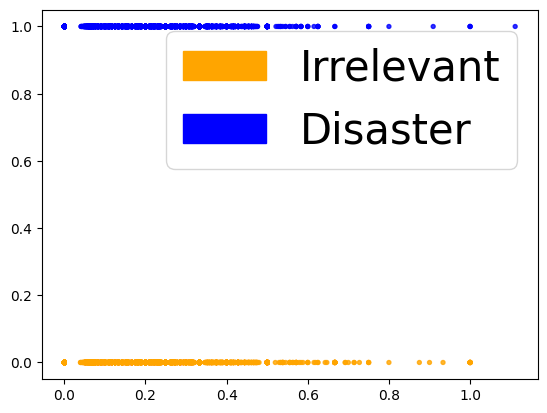

In [ ]:
fig = plt.figure()

colors = ['orange', 'blue']
plt.scatter(train_df['disaster_words_ratio'].tolist(), train_df['label'].tolist(), s=8, alpha=.8, c=[colors[int(k)] for k in train_df['label'].tolist()], cmap=matplotlib.colors.ListedColormap(colors))
orange_patch = mpatches.Patch(color='orange', label='Irrelevant')
blue_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[orange_patch, blue_patch], prop={'size': 30})
plt.show()

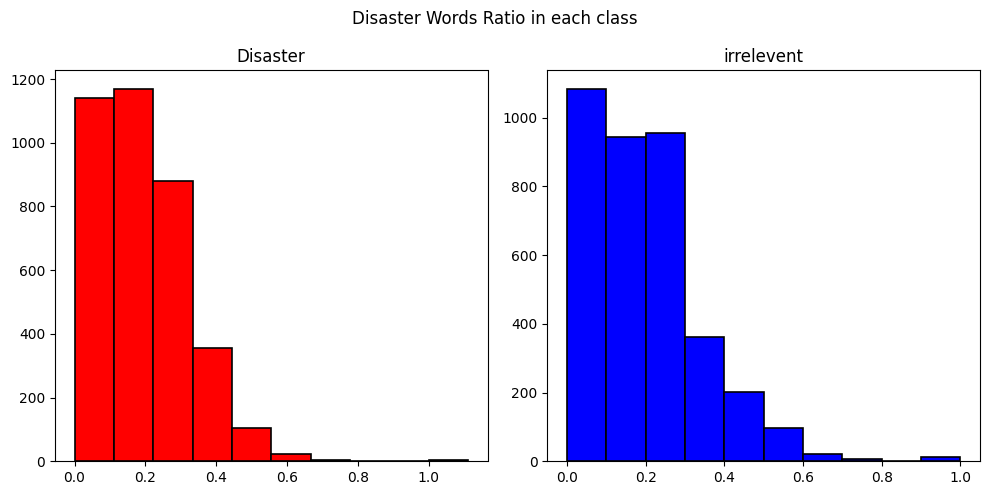

In [ ]:
fig,(ax1,ax2) = plt.subplots(1, 2, figsize=(10,5))
disaster_words_ratio1 = train_df[train_df['label'] == 1]['disaster_words_ratio']
ax1.hist(disaster_words_ratio1, color='red',edgecolor='black', linewidth=1.2)
ax1.set_title('Disaster')

disaster_words_ratio2 = train_df[train_df['label'] == 0]['disaster_words_ratio']
ax2.hist(disaster_words_ratio2, color='blue',edgecolor='black', linewidth=1.2)
ax2.set_title('irrelevent')

plt.suptitle("Disaster Words Ratio in each class")
plt.tight_layout()
plt.show()

Do you think it is a good way to classify text?!

In [ ]:
train_df.drop('disaster_words_ratio', inplace=True, axis=1)

Let's think of words frequencies in another way:


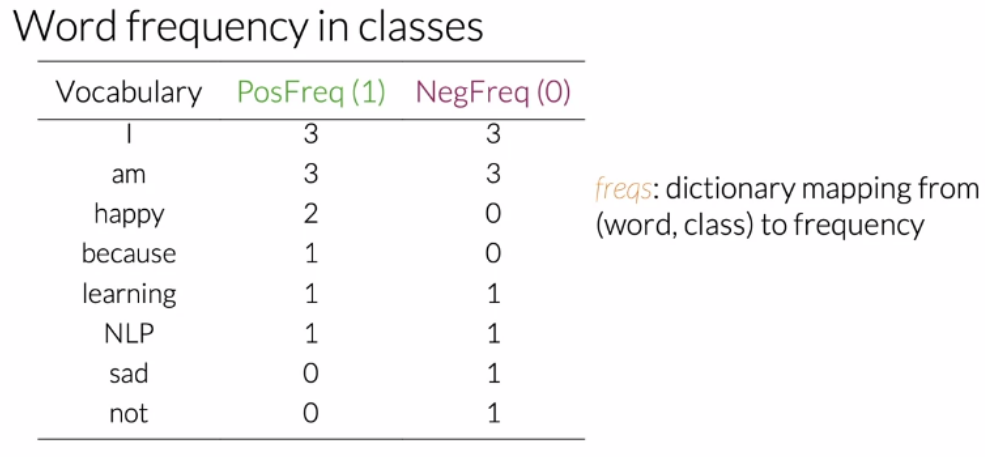


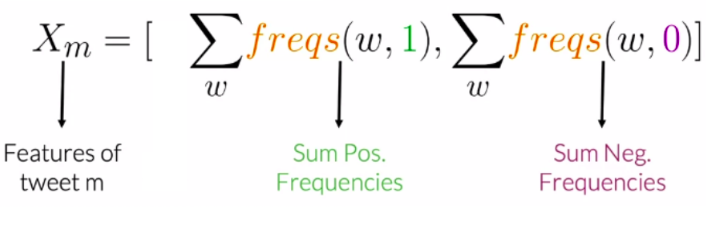

In [48]:
def extract_features(tweet, freqs):
    '''
    Input:
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output:
        x: a feature vector of dimension (1,2)
    '''
    word_list = tweet.split()

    x = np.zeros((1, 2))
    for word in word_list:
        x[0,0] += freqs.get((word, 1.0),0)

        x[0,1] += freqs.get((word, 0.0),0)

    return x

In [ ]:
train_df.iloc[0]['cleaned_text']

'angri orchard hard cider recal due to threat of explod bottl'

In [ ]:
extract_features(train_df.iloc[0]['cleaned_text'], freqs)

array([[1975., 1815.]])

In [ ]:
X_train = train_df['cleaned_text'].tolist()
X_test = test_df['cleaned_text'].tolist()

y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()

In [49]:
X = np.zeros((len(X_train), 2))

for i in range(len(X_train)):
    X[i, :]= extract_features(X_train[i], freqs)

**Visualizing the Vectors**: <br>
Now that we've created vectors, let's visualize them and see if we can identify some structure. In a perfect world, our vector would be so distinct that are two classes would be perfectly separated. Since visualizing data in handreds dimensions is hard, let's project it down to 2.

<ipython-input-65-c24e3c5afad1>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:,0], X[:,1], s=8, alpha=.8, c=[colors[int(k)] for k in y_train], cmap=matplotlib.colors.ListedColormap(colors))


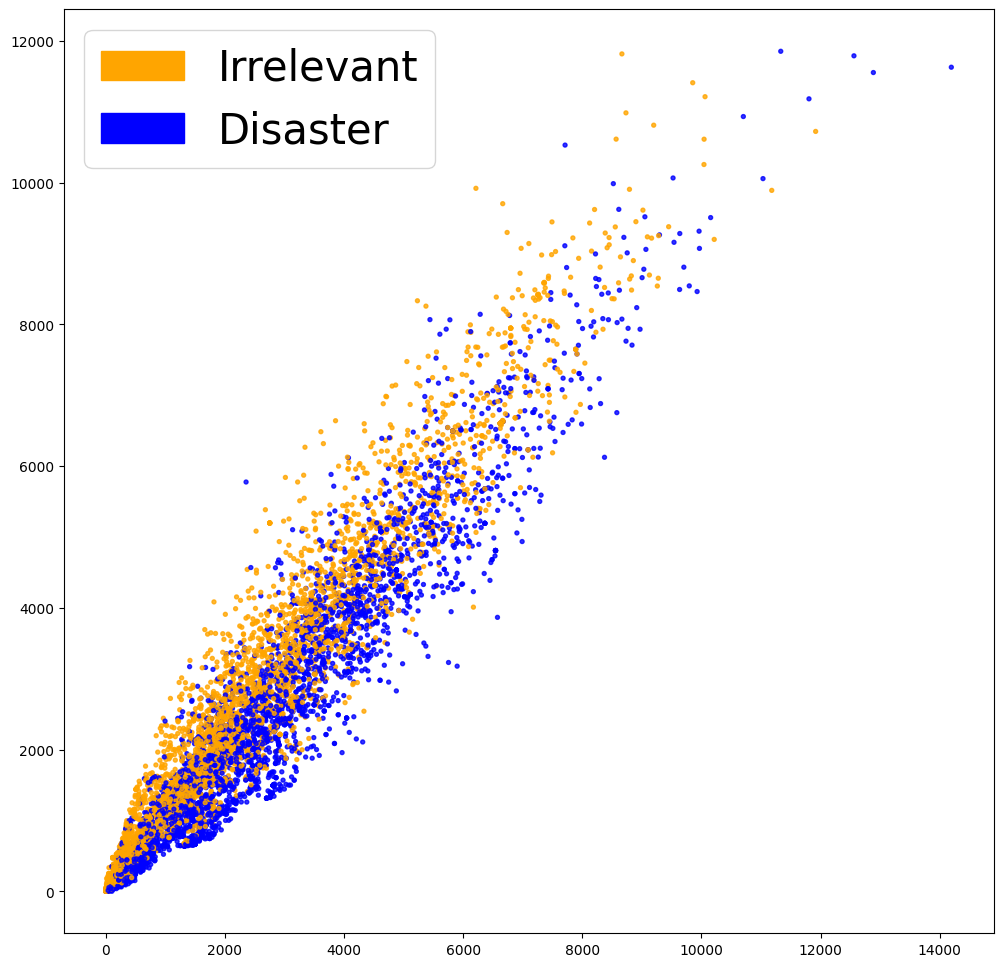

In [ ]:
fig = plt.figure(figsize=(12, 12))

colors = ['orange', 'blue']
plt.scatter(X[:,0], X[:,1], s=8, alpha=.8, c=[colors[int(k)] for k in y_train], cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='orange', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 30})
plt.show()

Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.


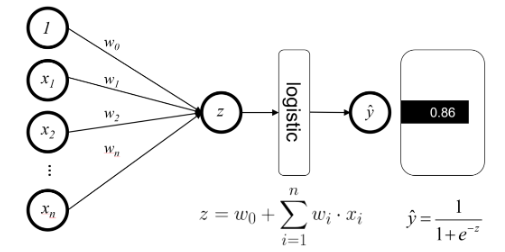

SigmoidFunction_701.svg

In [50]:
clf = LogisticRegression(random_state=40)
clf.fit(X, y_train)

X = np.zeros((len(X_test), 2))

for i in range(len(X_test)):
    X[i, :]= extract_features(X_test[i], freqs)
y_predicted = clf.predict(X)

In [51]:
accuracy_score(y_test, y_predicted)

0.7122030237580994

Because out task is a binary classification problem the worst method to solve it is the guess, the accuracy of the guess is 50%.<br>


Could normalizing the frequency could be better? Let's try:

In [41]:
def extract_features(tweet, freqs):
    '''
    Input:
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output:
        x: a feature vector of dimension (1,2)
    '''
    word_list = tweet.split()

    x = np.zeros((1, 2))
    for word in word_list:
        x[0,0] += freqs.get((word, 1.0),0)

        x[0,1] += freqs.get((word, 0.0),0)
    if np.any(np.isnan(x / np.sum(x))):
      return np.zeros((1, 2))
    return x / np.sum(x)

In [42]:
extract_features(train_df.iloc[0]['cleaned_text'], freqs)

array([[0.51656473, 0.48343527]])

In [43]:
X_train = train_df['cleaned_text'].tolist()
X_test = test_df['cleaned_text'].tolist()

y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()

In [44]:
X = np.zeros((len(X_train), 2))

for i in range(len(X_train)):
    X[i, :]= extract_features(X_train[i], freqs)

In [45]:
X

array([[0.51656473, 0.48343527],
       [0.49407075, 0.50592925],
       [0.55147646, 0.44852354],
       ...,
       [0.56499608, 0.43500392],
       [0.52775464, 0.47224536],
       [0.47713556, 0.52286444]])

In [46]:
clf = LogisticRegression(random_state=40)
clf.fit(X, y_train)

X = np.zeros((len(X_test), 2))

for i in range(len(X_test)):
    X[i, :]= extract_features(X_test[i], freqs)
y_predicted = clf.predict(X)

<ipython-input-41-6363995d8315>:16: RuntimeWarning: invalid value encountered in divide
  if np.any(np.isnan(x / np.sum(x))):


In [47]:
accuracy_score(y_test, y_predicted)

0.7143628509719222

**Remember the stemming dangers!!!**<br>
Let's try the same method without stemming:

In [ ]:
train_df = preprocesse(train_df, 'text', stem=False)
test_df = preprocesse(test_df, 'text', stem=False)
train_df.head()

text  label  \
0  Angry Orchard Hard Cider Recalled Due To Threa...      1   
1  @guardian Has Japan ever truly come to terms w...      1   
2  Plains All American Pipeline company may have ...      1   
3  People are finally panicking about cable TV ht...      0   
4  The far right racist #AvigdorLiberman calls fo...      1   

                                        cleaned_text  
0  angry orchard hard cider recalled due to threa...  
1   has japan ever truly come to terms with devas...  
2  plains all american pipeline company may have ...  
3      people are finally panicking about cable tv    
4  the far right racist avigdorliberman calls for...

In [ ]:
freqs = build_freqs(train_df['cleaned_text'].tolist(), train_df['label'].tolist())

In [ ]:
X_train = train_df['cleaned_text'].tolist()
X_test = test_df['cleaned_text'].tolist()

y_train = train_df['label'].tolist()
y_test = test_df['label'].tolist()

In [ ]:
X = np.zeros((len(X_train), 2))

for i in range(len(X_train)):
    X[i, :]= extract_features(X_train[i], freqs)

<ipython-input-72-c24e3c5afad1>:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:,0], X[:,1], s=8, alpha=.8, c=[colors[int(k)] for k in y_train], cmap=matplotlib.colors.ListedColormap(colors))


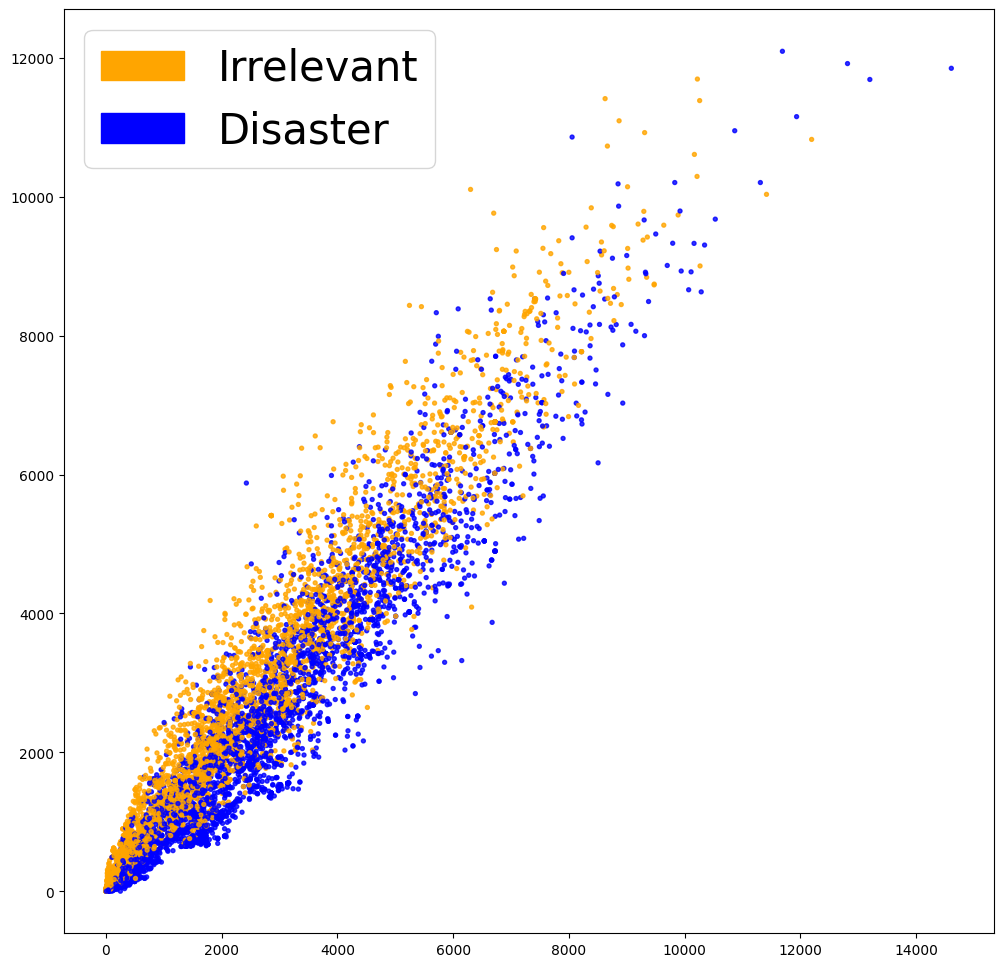

In [ ]:
fig = plt.figure(figsize=(12, 12))

colors = ['orange', 'blue']
plt.scatter(X[:,0], X[:,1], s=8, alpha=.8, c=[colors[int(k)] for k in y_train], cmap=matplotlib.colors.ListedColormap(colors))
red_patch = mpatches.Patch(color='orange', label='Irrelevant')
green_patch = mpatches.Patch(color='blue', label='Disaster')
plt.legend(handles=[red_patch, green_patch], prop={'size': 30})
plt.show()

In [ ]:
clf = LogisticRegression(random_state=40)
clf.fit(X, y_train)

X = np.zeros((len(X_test), 2))

for i in range(len(X_test)):
    X[i, :]= extract_features(X_test[i], freqs)
y_predicted = clf.predict(X)

In [ ]:
accuracy_score(y_test, y_predicted)

0.7181818181818181

#### Bag of words (BOW)
Motivation: we’re looking for marker words like “excellent” or “disappointed”<br>
Bag of Words (BoW) is a simple and widely used technique for text representation in natural language processing (NLP). It represents text data (documents) as vectors of word counts, disregarding grammar and word order but keeping multiplicity. Each unique word in the corpus is a feature, and the value of each feature is the count of occurrences of the word in the document.


For each token we will have a feature column, this is called **text vectorization**.

Steps to Create BoW Embeddings
- Tokenization:
- Vocabulary Building:<br>
  Create a vocabulary list of all unique words in the corpus.
- Vector Representation:<br>
  For each document, create a vector where each element corresponds to a word in the vocabulary. The value is the count of occurrences of that word in the document.

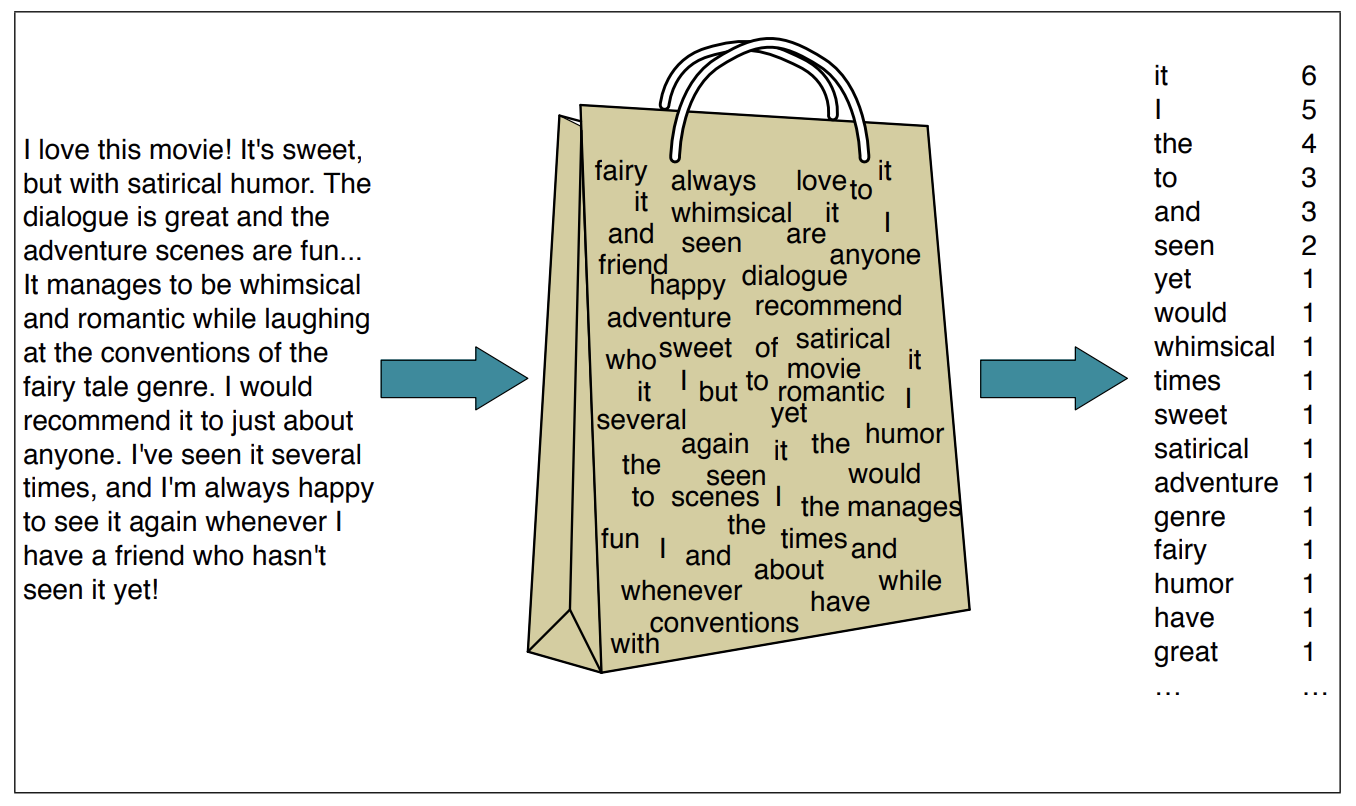

Example:

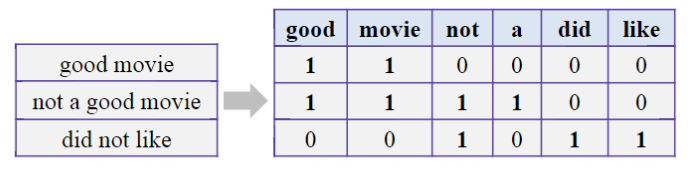

<Axes: >

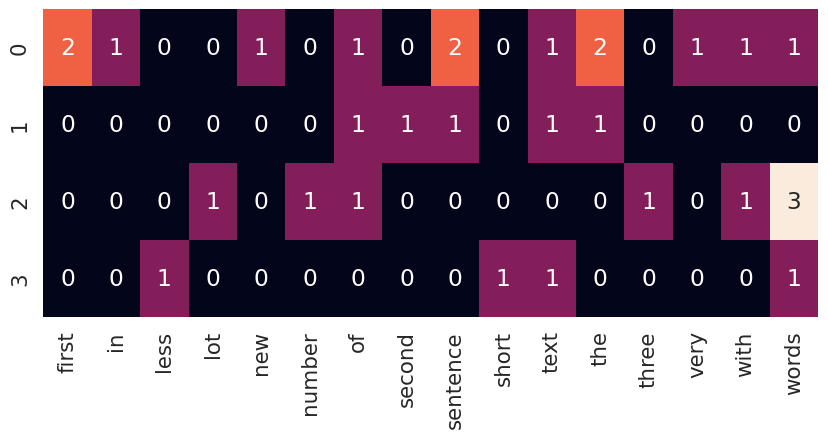

In [ ]:
# create CountVectorizer object
vectorizer = CountVectorizer()
corpus = [
          'Text of the very first new sentence with the first words in sentence.',
          'Text of the second sentence.',
          'Number three with lot of words words words.',
          'Short text, less words.',
]
# learn the vocabulary and store CountVectorizer sparse matrix in term_frequencies
term_frequencies = vectorizer.fit_transform(corpus)
vocab = vectorizer.get_feature_names_out()
# convert sparse matrix to numpy array
term_frequencies = term_frequencies.toarray()
# visualize term frequencies
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(10,4))         # Sample figsize in inches
sns.heatmap(term_frequencies, annot=True, cbar = False, xticklabels = vocab, ax=ax)

Note:
Vectorizers in sklearn return a *sparse matrix*. This is a data type that is optimized for matrices with only a few non-zero elements, which only keeps track of the non-zero elements reducing the memory load.

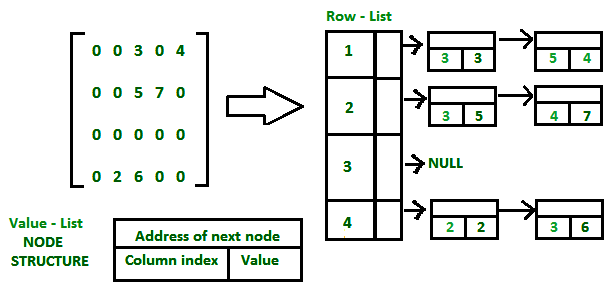

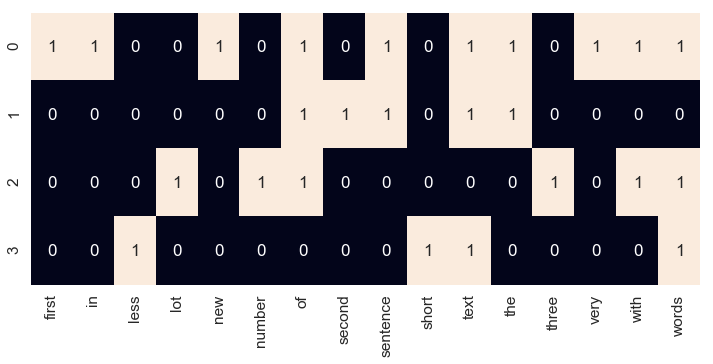

In [ ]:
one_hot_vectorizer = CountVectorizer(binary=True)
one_hot = one_hot_vectorizer.fit_transform(corpus).toarray()

sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(one_hot, annot=True, cbar = False, xticklabels = vocab)

lets try it in our dataset

In [ ]:
# Normalize words in vectorization is so improtant, why?
train_df = preprocesse(train_df, 'text')
test_df = preprocesse(test_df, 'text')

In [ ]:
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
len(X_train)

7368

In [ ]:
len(X_test)

1870

In [ ]:
X_train_counts.toarray().shape

(7368, 12160)

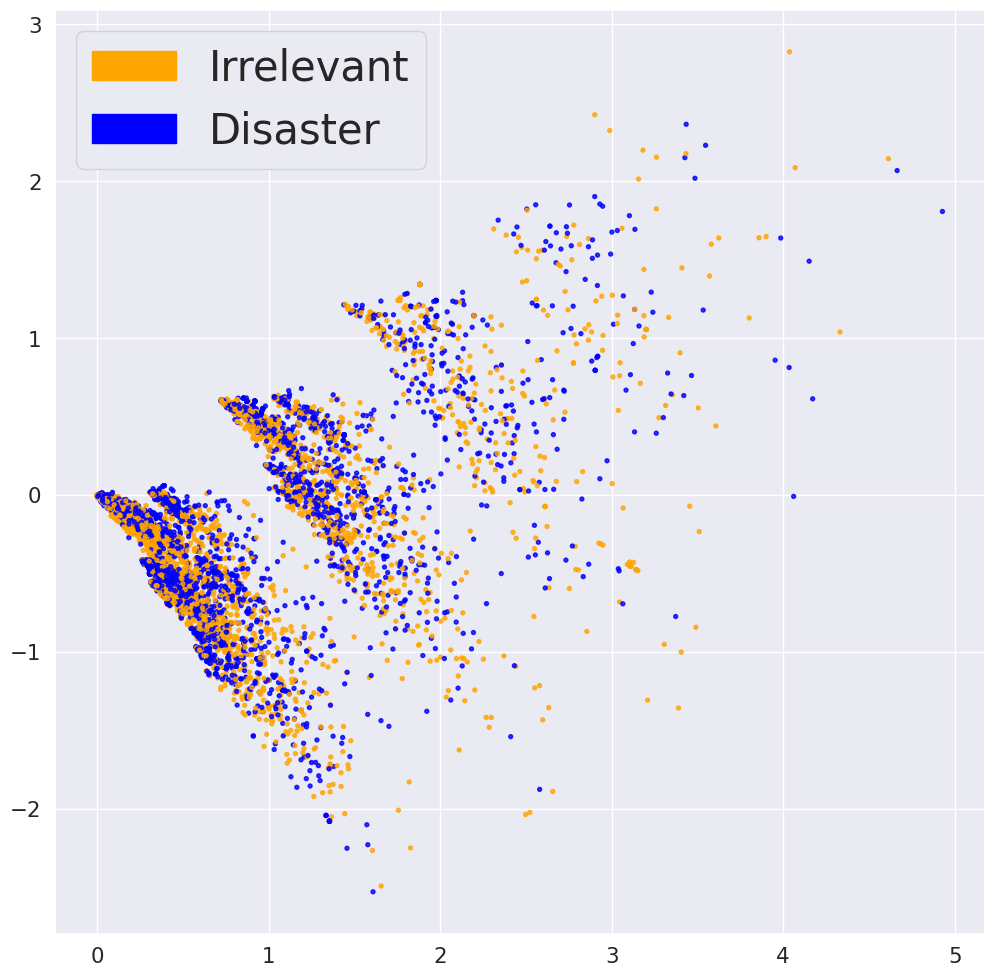

In [ ]:
def plot_LSA(vectors, labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(vectors)
        lsa_scores = lsa.transform(vectors)
        color_mapper = {label:idx for idx,label in enumerate(set(labels))}
        color_column = [color_mapper[label] for label in labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=labels,
                        cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(12, 12))
plot_LSA(X_train_counts, y_train)
plt.show()

In [ ]:
clf = LogisticRegression(random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted = clf.predict(X_test_counts)

In [ ]:
accuracy_score(y_test, y_predicted)

0.8207343412526998

Problem:

**High frequency token**:
    - Articles, prepositions, etc. (example: and, a, the)
    - They are called stop-words, they won’t help us to discriminate texts -> remove them
    - accutully for 1-grams these words could be removed as a preprocessing step since they are the same for all English texts
    
#### Removing stop words for tokens

In [ ]:
stop_words = set(stopwords.words('english'))
print(stop_words)

{'ourselves', 'his', 'shouldn', 'down', 'him', 'mustn', "it's", 'so', 'above', 'both', 'until', "isn't", "that'll", 'has', 'now', "hasn't", 'more', 'doesn', "hadn't", 'by', 'no', 've', 'which', 'that', 'won', 'any', 'but', 'ours', 'weren', 'when', 'after', 'hadn', 'how', 'hasn', 'o', "mustn't", 'nor', 'couldn', 'shan', 'very', 'with', 'up', "weren't", 'where', 'before', 'below', 'our', 'other', 'just', 'can', 'through', 'and', 'why', "doesn't", 'haven', 'than', 'are', 'a', 'while', 'further', 'same', "didn't", 'ain', "won't", 'if', 'should', 'some', 'am', 'for', "wasn't", 'as', 'they', 'she', 'its', 'were', 'himself', 'it', 'did', 'against', 'off', "you'd", "don't", 'who', 'these', 'once', 'out', 'yourself', "you're", 'was', "should've", 're', 'from', 'have', 'isn', 'to', 'their', 'about', 'into', 't', "you've", "shan't", 'do', 'them', 'itself', 'under', 'all', 'whom', 'having', 'then', 'few', 'this', "aren't", 'didn', 'theirs', 'yours', 'hers', 'the', 'i', 'themselves', "you'll", "cou

lets remove stopwords from our dataset and check classifer accuracy again

In [ ]:
def remove_stopwords(df, text_field):
    df['cleaned_text_without_stopwords'] = df[text_field].apply(lambda x: " ".join([w for w in x.split() if not w in stop_words]))
    return df

train_df = remove_stopwords(train_df, 'cleaned_text')
train_df.head()

text  label  \
0  Angry Orchard Hard Cider Recalled Due To Threa...      1   
1  @guardian Has Japan ever truly come to terms w...      1   
2  Plains All American Pipeline company may have ...      1   
3  People are finally panicking about cable TV ht...      0   
4  The far right racist #AvigdorLiberman calls fo...      1   

                                        cleaned_text  \
0  angri orchard hard cider recal due to threat o...   
1  ha japan ever truli come to term with devast a...   
2  plain all american pipelin compani may have sp...   
3               peopl are final panick about cabl tv   
4  the far right racist avigdorliberman call for ...   

                      cleaned_text_without_stopwords  
0  angri orchard hard cider recal due threat expl...  
1  ha japan ever truli come term devast mass murd...  
2  plain american pipelin compani may spill 40 pe...  
3                         peopl final panick cabl tv  
4  far right racist avigdorliberman call destruct...

In [ ]:
test_df = remove_stopwords(test_df, 'cleaned_text')

In [ ]:
X_train = train_df['cleaned_text_without_stopwords'].tolist()
X_test = test_df['cleaned_text_without_stopwords'].tolist()

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
X_train_counts.toarray().shape

(7368, 12073)

In [ ]:
clf = LogisticRegression(random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted = clf.predict(X_test_counts)

In [ ]:
accuracy_score(y_test, y_predicted)

0.8153347732181425

What is the problem?!<br>
Note the folowing sentences and the negation words effect on their meaning:<br>

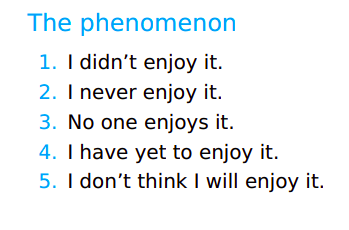

In [ ]:
train_df.drop('cleaned_text_without_stopwords', inplace=True, axis=1)
test_df.drop('cleaned_text_without_stopwords', inplace=True, axis=1)

In [ ]:
negation_words = ['not', 'never', 'neither', 'nor', 'barely','hardly', 'scarcely', 'seldom',
                  'rarely', 'nothing', 'none', 'no', 'nobody','nowhere', 'n\'t']

In [ ]:
def replace_negations(tweet, symbol='_NEG'):
    word_list = tweet.split()
    for word in word_list:
      if word in negation_words or word.endswith('n\'t'):
        tweet = tweet.replace(word, symbol)
    return tweet


train_df['cleaned_text_replaced_negations'] = train_df['cleaned_text'].apply(lambda x: replace_negations(x))
train_df = remove_stopwords(train_df, 'cleaned_text_replaced_negations')
train_df.head()

text  label  \
0  Angry Orchard Hard Cider Recalled Due To Threa...      1   
1  @guardian Has Japan ever truly come to terms w...      1   
2  Plains All American Pipeline company may have ...      1   
3  People are finally panicking about cable TV ht...      0   
4  The far right racist #AvigdorLiberman calls fo...      1   

                                        cleaned_text  \
0  angri orchard hard cider recal due to threat o...   
1  ha japan ever truli come to term with devast a...   
2  plain all american pipelin compani may have sp...   
3               peopl are final panick about cabl tv   
4  the far right racist avigdorliberman call for ...   

                     cleaned_text_replaced_negations  \
0  angri orchard hard cider recal due to threat o...   
1  ha japan ever truli come to term with devast a...   
2  plain all american pipelin compani may have sp...   
3               peopl are final panick about cabl tv   
4  the far right racist avigdorliberman call for ...   

                      cleaned_text_without_stopwords  
0  angri orchard hard cider recal due threat expl...  
1  ha japan ever truli come term devast mass murd...  
2  plain american pipelin compani may spill 40 pe...  
3                         peopl final panick cabl tv  
4  far right racist avigdorliberman call destruct...

In [ ]:
before = train_df.loc[102]['cleaned_text']
after = train_df.loc[102]['cleaned_text_replaced_negations']

print(f'Before replacemnet: {before}')
print(f'After replacemnet: {after}')

Before replacemnet: haha exactli cosima is definit in the hot seat lol ' it' shay ' is no differ from a bomb that got explod
After replacemnet: haha exactli cosima is definit in the hot seat lol ' it' shay ' is _NEG differ from a bomb that got explod


In [ ]:
test_df['cleaned_text_replaced_negations'] = test_df['cleaned_text'].apply(lambda x: replace_negations(x))
test_df = remove_stopwords(test_df, 'cleaned_text_replaced_negations')

In [ ]:
X_train = train_df['cleaned_text_without_stopwords'].tolist()
X_test = test_df['cleaned_text_without_stopwords'].tolist()

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
X_train_counts.toarray().shape

(7476, 12085)

In [ ]:
clf = LogisticRegression(random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted = clf.predict(X_test_counts)

In [ ]:
accuracy_score(y_test, y_predicted)

0.8165775401069518

What about numbers, they could be useful to distincte disaster tweets (victims count for example) form non-disaster.<br>

let's try:

In [ ]:
def remove_numbers(df, text_field, replacement=''):
    df['final_cleaned_text'] = df[text_field].apply(lambda x: re.sub(r'\d+', replacement, x))
    return df

train_df = remove_numbers(train_df, 'cleaned_text_without_stopwords')
train_df.head()

text  label  \
0  Angry Orchard Hard Cider Recalled Due To Threa...      1   
1  @guardian Has Japan ever truly come to terms w...      1   
2  Plains All American Pipeline company may have ...      1   
3  People are finally panicking about cable TV ht...      0   
4  The far right racist #AvigdorLiberman calls fo...      1   

                                        cleaned_text  \
0  angri orchard hard cider recal due to threat o...   
1  ha japan ever truli come to term with devast a...   
2  plain all american pipelin compani may have sp...   
3               peopl are final panick about cabl tv   
4  the far right racist avigdorliberman call for ...   

                     cleaned_text_replaced_negations  \
0  angri orchard hard cider recal due to threat o...   
1  ha japan ever truli come to term with devast a...   
2  plain all american pipelin compani may have sp...   
3               peopl are final panick about cabl tv   
4  the far right racist avigdorliberman call for ...   

                      cleaned_text_without_stopwords  \
0  angri orchard hard cider recal due threat expl...   
1  ha japan ever truli come term devast mass murd...   
2  plain american pipelin compani may spill 40 pe...   
3                         peopl final panick cabl tv   
4  far right racist avigdorliberman call destruct...   

                                  final_cleaned_text  
0  angri orchard hard cider recal due threat expl...  
1  ha japan ever truli come term devast mass murd...  
2  plain american pipelin compani may spill  perc...  
3                         peopl final panick cabl tv  
4  far right racist avigdorliberman call destruct...

In [ ]:
before = train_df.loc[2]['cleaned_text']
after = train_df.loc[2]['final_cleaned_text']

print(f'Before replacemnet: {before}')
print(f'After replacemnet: {after}')

Before replacemnet: plain all american pipelin compani may have spill 40 percent more crude oil than previous estim
After replacemnet: plain american pipelin compani may spill percent crude oil previous estim


In [ ]:
test_df = remove_numbers(test_df, 'cleaned_text_without_stopwords')

In [ ]:
X_train = train_df['final_cleaned_text'].tolist()
X_test = test_df['final_cleaned_text'].tolist()

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
X_train_counts.toarray().shape

(7476, 11436)

In [ ]:
clf = LogisticRegression(random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted = clf.predict(X_test_counts)

In [ ]:
accuracy_score(y_test, y_predicted)

0.8106951871657754

The accuracy decreased, let us replace numbers with _NUM:

In [ ]:
train_df = remove_numbers(train_df, 'cleaned_text_without_stopwords', '_NUM')
train_df.head()

text  label  \
0  Angry Orchard Hard Cider Recalled Due To Threa...      1   
1  @guardian Has Japan ever truly come to terms w...      1   
2  Plains All American Pipeline company may have ...      1   
3  People are finally panicking about cable TV ht...      0   
4  The far right racist #AvigdorLiberman calls fo...      1   

                                        cleaned_text  \
0  angri orchard hard cider recal due to threat o...   
1  ha japan ever truli come to term with devast a...   
2  plain all american pipelin compani may have sp...   
3               peopl are final panick about cabl tv   
4  the far right racist avigdorliberman call for ...   

                     cleaned_text_replaced_negations  \
0  angri orchard hard cider recal due to threat o...   
1  ha japan ever truli come to term with devast a...   
2  plain all american pipelin compani may have sp...   
3               peopl are final panick about cabl tv   
4  the far right racist avigdorliberman call for ...   

                      cleaned_text_without_stopwords  \
0  angri orchard hard cider recal due threat expl...   
1  ha japan ever truli come term devast mass murd...   
2  plain american pipelin compani may spill 40 pe...   
3                         peopl final panick cabl tv   
4  far right racist avigdorliberman call destruct...   

                                  final_cleaned_text  
0  angri orchard hard cider recal due threat expl...  
1  ha japan ever truli come term devast mass murd...  
2  plain american pipelin compani may spill _NUM ...  
3                         peopl final panick cabl tv  
4  far right racist avigdorliberman call destruct...

In [ ]:
before = train_df.loc[2]['cleaned_text']
after = train_df.loc[2]['final_cleaned_text']

print(f'Before replacemnet: {before}')
print(f'After replacemnet: {after}')

Before replacemnet: plain all american pipelin compani may have spill 40 percent more crude oil than previous estim
After replacemnet: plain american pipelin compani may spill _NUM percent crude oil previous estim


In [ ]:
test_df = remove_numbers(test_df, 'cleaned_text_without_stopwords')

In [ ]:
X_train = train_df['final_cleaned_text'].tolist()
X_test = test_df['final_cleaned_text'].tolist()

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [ ]:
X_train_counts.toarray().shape

(7476, 11492)

In [ ]:
clf = LogisticRegression(random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted = clf.predict(X_test_counts)

In [ ]:
accuracy_score(y_test, y_predicted)

0.8117647058823529

Another Problems:<br>
   - We lose word order, hence the name “bag of words”, This means that “Apple is looking at buying a U.K. startup.” and “Startup is looking at buying an Apple.” will have the same BoW representation, despite having different meanings.
   - Counters are not normalized.


   ***Let's preserve some ordering***<br>
We can count token pairs, triplets, etc. Also known as **n-grams**


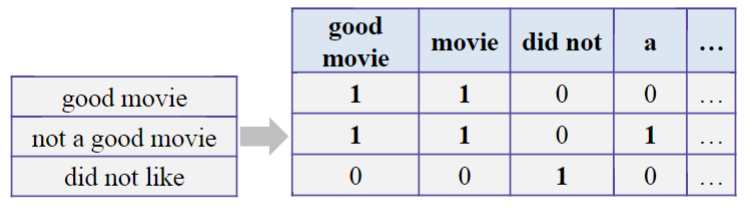

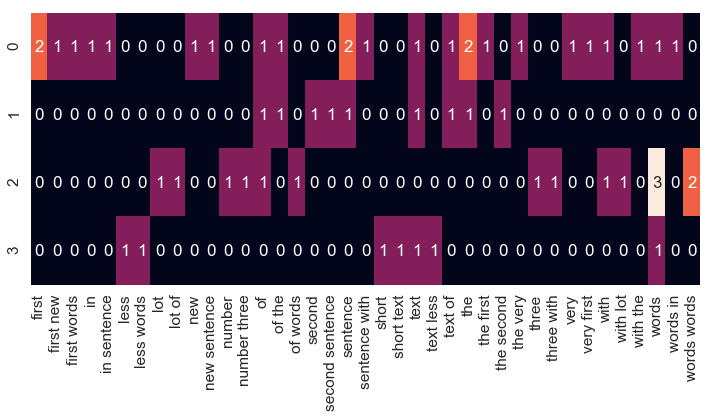

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,2))
ngrams = vectorizer.fit_transform(corpus).toarray()

vocab = vectorizer.get_feature_names_out()

sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(ngrams, annot=True, cbar = False, xticklabels = vocab)

BoW Problems:<br>
- High Dimensionality
  - Large Vocabulary Size:<br>
    The dimensionality of BoW vectors is equal to the number of unique words in the corpus, which can be extremely large. This leads to very high-dimensional vectors, resulting in increased computational cost and memory usage.
  - Sparsity:<br>
    Most documents use only a small fraction of the total vocabulary, resulting in sparse vectors with many zero values. This sparsity can make storage and computation inefficient.
- Lack of Contextual Information
  - Word Order Ignored
  - Loss of Syntax and Semantics:
    The embedding does not capture syntactic and semantic relationships between words. For instance, “bank” in the context of a financial institution and “bank” in the context of a riverbank will have the same representation.
- Lack of Handling of Synonymy<br>
  Synonyms (different words with similar meaning) are treated as completely unrelated features. For example, “happy” and “joyful” will have different vector representations even though they have similar meanings.
- Fixed Vocabulary<br>
  BoW cannot handle words that were not present in the training corpus. Any new word encountered will be ignored or misrepresented, leading to potential loss of information.
- Feature Independence Assumption
  No Inter-Feature Relationships: BoW assumes that the presence or absence of a word in a document is independent of other words. This independence assumption ignores any potential relationships or dependencies between words, which can be crucial for understanding context and meaning.
- Scalability Issues<BR>
  Computational Inefficiency: As the size of the corpus increases, the vocabulary size also increases, leading to scalability issues. High-dimensional vectors require more computational resources for processing, storing, and analyzing the data.
- No Weighting Mechanism<BR>
  Equal Importance: In its simplest form, BoW treats all words with equal importance, which is not always appropriate. Common but less informative words (e.g., “the”, “is”) are treated the same as more informative words (e.g., “cat”, “bank”).
- Lack of Generalization<BR>
  Poor Performance on Short Texts: BoW can be particularly ineffective for short texts or documents with limited content, where the lack of context and the sparse nature of the vector representation can lead to poor performance.




Let’s remove some n-grams from features based on their occurrence frequency in documents of our corpus to handle High Dimensionality problem:

**Low frequency n-grams:**<br>
- Typos, rare n-grams
- We don’t need them either, otherwise we will likely **overfit**



**Medium frequency n-grams:** <br>
- Those are good n-grams



*There’re a lot of medium frequency n-grams*
- It proved to be useful to look at **n-gram frequency in our corpus** for filtering out bad n-grams
- What if we use it for **ranking** of medium frequency n-grams?
- **Idea**: the n-gram with smaller frequency can be more discriminating because it can capture a characteristics in the text (**reweighting** raw counts)


#### TF-IDF
Term frequency (TF) <br>
**tf(*t*,*d*)** –frequency for term (or n-gram) *t*  in document *d*

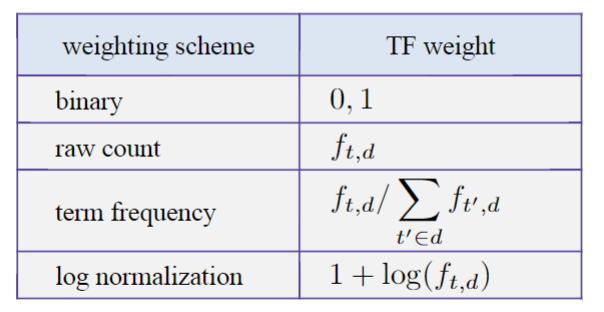

log: gives logarithmic scale to the counts

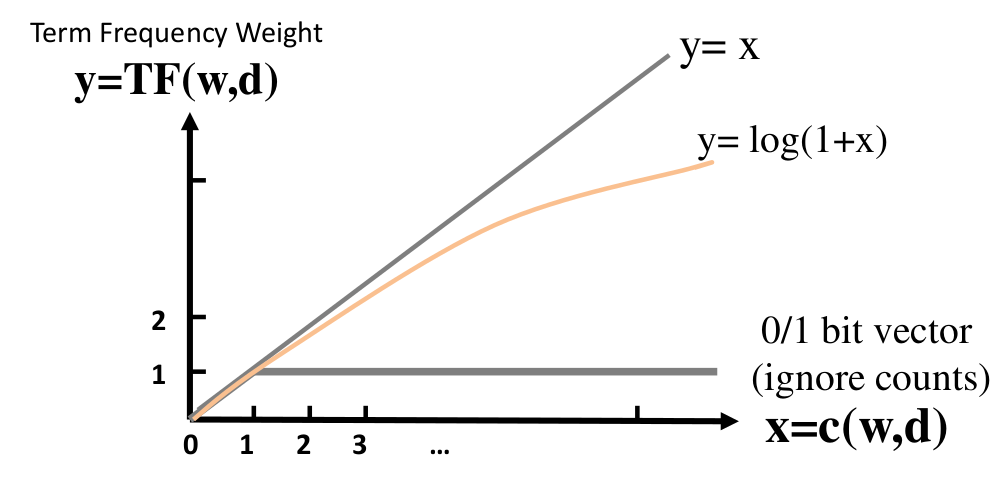

### TF-IDF
\begin{equation*}tfidf(t,d,D) = tf(t,d) × idf(t,D) \end{equation*}<br>

Inverse Dense Frequency(IDF): the inverse document frequency of the word across a collection of documents. Rare words have high scores, common words have low scores.<br>

\begin{align}
tf(t, d) = \frac{Number\ of\ times\ term\ t\ appears\ in\ a\ document\ d}{Total\ number\ of\ terms\ in\ the\ document\ d}
\end{align}

\begin{align}
IDF(t, D)=log\frac{Total\ number\ of\ documents\ D}{Number\ of\ documents\ with\ term\ t\ in\ it}
\end{align}

A high weight in TF-IDF is reached by a high term frequency(in the given document) and a low document frequency of the term in the whole collection of documents


## Better BOW
- Replace counters with TF-IDF
- Normalize the result row-wise (e.g. divide by L2-norm (the root of the sum of the squares of all elements))

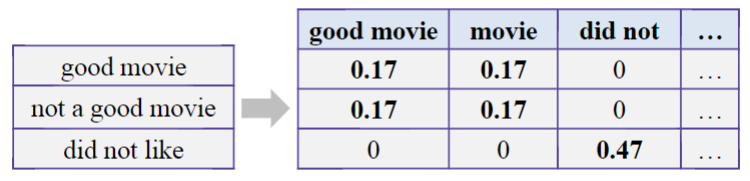

In [ ]:
texts = ["good movie", "not a good movie", "did not like", "i like it", "good one"]
# using default tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
tfidf.fit(texts) #calcualate the values
features = tfidf.transform(texts) #make the vectors
pd.DataFrame(
    features.todense(),
    columns=tfidf.get_feature_names_out()
)

good movie      like     movie       not
0    0.707107  0.000000  0.707107  0.000000
1    0.577350  0.000000  0.577350  0.577350
2    0.000000  0.707107  0.000000  0.707107
3    0.000000  1.000000  0.000000  0.000000
4    0.000000  0.000000  0.000000  0.000000

max_df is used for removing terms that appear too frequently, also known as "corpus-specific stop words". For example:<br>

- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".<br>
- max_df = 25 means "ignore terms that appear in more than 25 documents".<br>

The default max_df is 1.0, which means "ignore terms that appear in more than 100% of the documents". Thus, the default setting does not ignore any terms.<br>


min_df is used for removing terms that appear too infrequently. For example:<br>

- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".<br>
- min_df = 5 means "ignore terms that appear in less than 5 documents".<br>

The default min_df is 1, which means "ignore terms that appear in less than 1 document". Thus, the default setting does not ignore any terms.



In [ ]:
X_train = train_df['cleaned_text'].tolist()
X_test = test_df['cleaned_text'].tolist()

In [ ]:
def tfidf(data, min_df, max_df):
    tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.75, ngram_range=(1, 2))

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

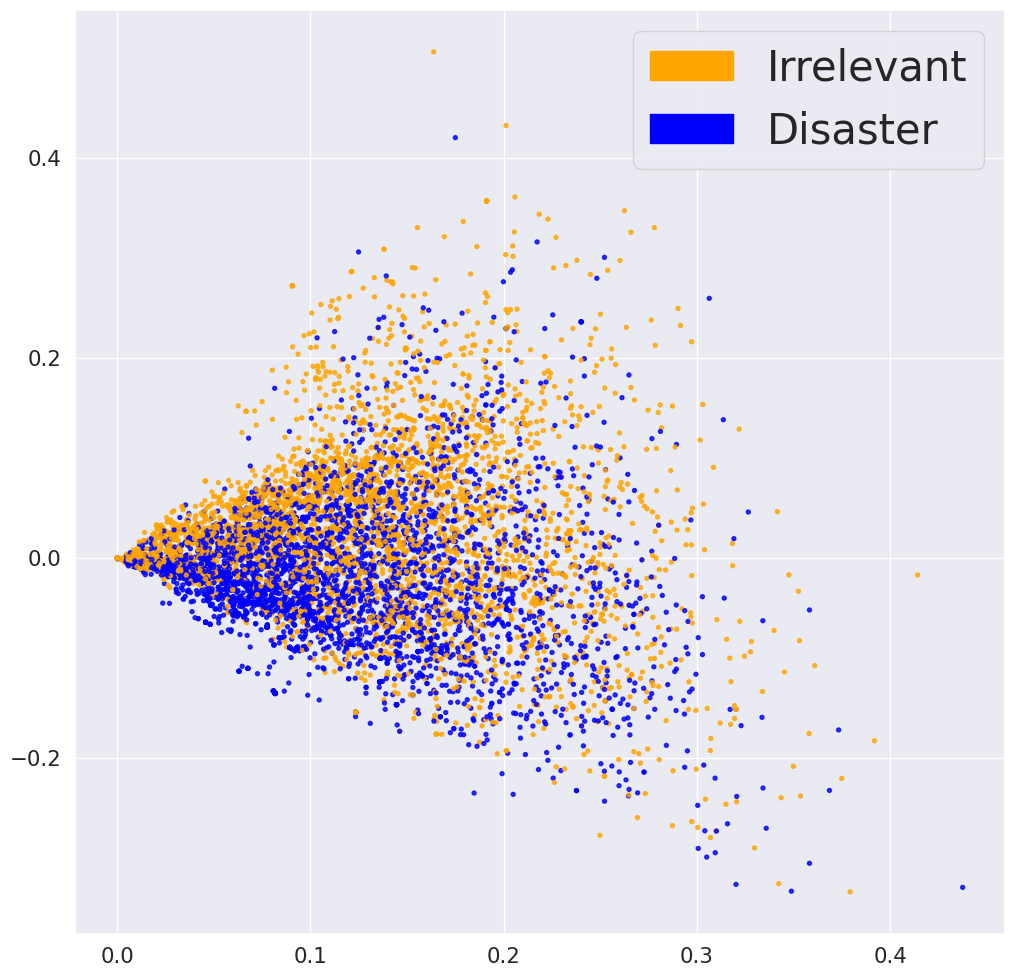

In [ ]:
fig = plt.figure(figsize=(12, 12))
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [ ]:
clf = LogisticRegression(random_state=40)
clf.fit(X_train_tfidf, y_train)

y_predicted = clf.predict(X_test_tfidf)

In [ ]:
accuracy_score(y_test, y_predicted)

0.8203208556149733

TFIDF problems:
In addtion to BoW lack of context and semantic understanding problems we have:
- Bias Towards Rare Terms <br>
  While the IDF component of TF-IDF aims to balance the frequency of terms, it can sometimes overly emphasize rare terms. This might lead to overvaluing words that appear infrequently but are not necessarily more relevant or important in the context of the document.

- Normalization Issues
  The normalization process in TF-IDF (e.g., dividing by the total number of words in a document) may not always be effective in balancing document lengths and word frequencies, potentially leading to skewed results.<br>
  If a document contains 100 occurrences of the term “computer,” is it really twice as relevant as a document that contains 50 occurrences? We could argue that if the term “computer” occurs a large enough number of times, the document is almost certainly relevant, and any more occurrences doesn’t increase the likelihood of relevance. So, we want to control the contribution of TF when a term is likely to be saturated.


In general, Raw frequency is very skewed and not very discriminative.

####  Extra ideas to view

##### Best Match 25 (BM25)

BM25 is a probabilistic retrieval framework that extends the idea of TF-IDF and improves some drawbacks of TF-IDF which concern with term saturation and document length.

BM25 solves this issue by introducing a parameter k that controls the shape of this saturation curve preventing a term’s frequency from having an unbounded impact on the document’s relevance.

In addtion, BM25 introduces a sophisticated way of handling document length. Unlike TF-IDF, which may unfairly penalize longer documents, BM25 normalizes for length in a more balanced manner, reducing the impact of document length on the calculation of relevance.


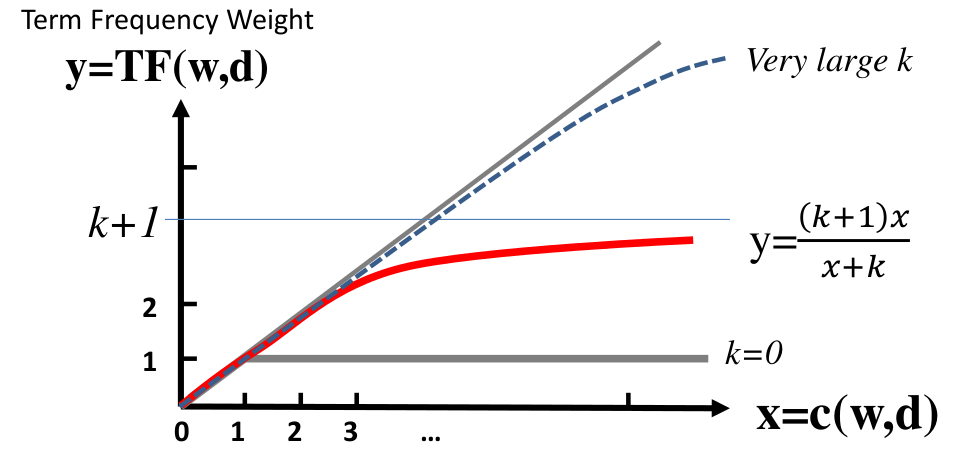

##### Term-term matrix

An alternative to using the **term-document matrix** to represent words as vectors of
document counts, is to use the **term-term matrix**, also called the **word-word matrix** or the **term-context matrix** or **co-occurrence matrix**, in which the columns are labeled by words rather  than documents. This matrix is thus of dimensionality |V|×|V| and each cell records
the number of times the row (target) word and the column (context) word co-occur
in some context in some training corpus. The context could be the document, in
which case the cell represents the number of times the two words appear in the same
document. It is most common, however, to use smaller contexts, generally a window around the word, for example of 4 words to the left and 4 words to the right,
in which case the cell represents the number of times (in some training corpus) the
column word occurs in such a ±4 word window around the row word. Here are four
examples of words in their windows:

<center>is traditionally followed by <font color='gray'>cherry</font> pie, a traditional dessert <br>
often mixed, such as <font color='gray'>strawberry</font> rhubarb pie. Apple pie<br>
computer peripherals and personal <font color='gray'>digital</font> assistants. These devices usually<br>
a computer. This includes <font color='gray'>information</font> available on the internet</center>

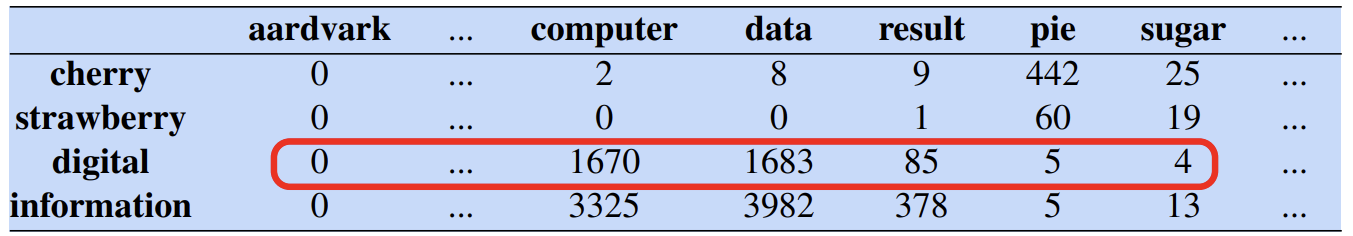



##### Pointwise Mutual Information (PMI)

An alternative weighting function to tf-idf, PPMI (positive pointwise mutual information), is used for term-term-matrices. PPMI draws on the intuition that the best way to weigh
the association between two words is to ask how much more the two words co-occur
in our corpus than we would have a priori expected them to appear by chance.

The pointwise mutual information between a target word w and a context word c:

\begin{align}
P(w|c) = log\frac{p(w,c)}{p(w).p(c)}
\end{align}